# Spotify Hit Prediction with Neural Networks

CS109B Final Project

Henry Fisher, Bettie Closs, Sam Levin, Kemi Okoye

## Table of Contents:
- Section 1: Introduction, Data Acquisition, EDA
  - 1.1: Introduction
  - 1.2: Dataset Summary Information
  - 1.3: Feature Visualizations

- Section 2: Preprocessing
  - 2.1: Missingness
  - 2.2: Class Imbalance
  - 2.3: Encoding
  - 2.4: Scaling
  - 2.5: Feature Importance
  - 2.6: EDA Review

- Section 3: Baseline Model
  - 3.1: Research Question
  - 3.2: Preparing the Dataset
  - 3.3: Baseline Model Construction and Fitting
  - 3.4: Training History Visualization
  - 3.5: Baseline Model Selection/Justification
  - 3.6: Baseline Results Interpretation and Analysis

- Section 4: Final Model
  - 4.1: Final Model Pipeline
  - 4.2: Final Model GridSearch
  - 4.3: Final Model Construction and Fitting
  - 4.4: Training History Visualization
  - 4.5: Test Predictions
  - 4.6: Test Dataset "new_songs"
  - 4.7: Test Predictions "new_songs"

- Section 5: Conclusion

## Section 1: Introduction and Data Acquisition

The following code loads the "Spotify Genre Joined" Kaggle dataset, which is available as a downloadable link at https://www.kaggle.com/datasets/akiboy96/spotify-genre-joined.

This is a version of the original Kaggle set "The Spotify Hit Predictor Dataset (1960-2019)", found at https://www.kaggle.com/datasets/theoverman/the-spotify-hit-predictor-dataset?resource=download&select=dataset-of-90s.csv.

The difference between the "Spotify Genre Joined" dataset and the Spotify Hit Predictor dataset is that these are the same dataset, but with the genre of the songs webscraped and added as a new column "genre" in the former.

Note: This code can (and was) fully run in colab and does not require a specific environment or unique libraries to run, aside from the basics, such as:
- *matplotlib*
- *numpy*
- *tensorflow*
- *os*
- *scikit*
- *sklearn*
- *pandas*
- *seaborn*

and all needed functions are inserted/called in the notebook!


### Section 1.1: Introduction

The music industry is a multi-billion dollar sector. While music is an artform, and therefore resonates differently with different people, there may be certain aspects of a song that make it more attractive to a wider audience. Considering the size of this sector, there is great value in understanding what factors make a song popular, as charting can translate to tangible sales of albums, merchandise, and concert tickets.

For our project, we investigate this relationship and aim to learn patterns on what makes a song a “hit” vs. a “flop” based on U.S. Billboard records. The criteria for a “hit” is having been listed on the Billboard Hot-100. With the help of our model, we explore whether we can correctly predict whether a song is a success based on its musical features.  Furthermore, we ask what specific features of a song are most strongly associated with its success, and how this may have changed across different decades.

In order to achieve this goal, we utilize the Spotify Hit Predictor Dataset, which contains 41,099 data points and various descriptors of songs such as artist, track title, genre, danceability, energy, key, loudness, mode (major or minor scale), speechiness, acousticness, instrumentalness, liveness (performed live), tempo, duration (in seconds), time signature, valence (positivity), and popularity (our target variable of hit or flop).

Our initial EDA revealed that certain musical traits such as higher valence, danceability, and loudness were positively associated with a song’s popularity, while acousticness and liveness were negatively associated. These patterns suggested that more energetic, "fun" songs tend to perform better commercially, while more acoustic or live performances are less likely to chart. Building on these insights, we tested two versions of our baseline model: one using only pre-release song features, and another incorporating Spotify API features. The higher performance of the full model highlighted that commercial success is not simply driven by basic components like tempo or genre, but rather by more complex, nonlinear combinations of musical qualities. This shift in understanding reinforced our decision to use a neural network, which is better suited to capture these complex relationships.

Moving forward in this milestone, we continue refining our neural network to deepen our understanding of what drives a song’s success and to improve our ability to predict future "hits."

### Section 1.2: Dataset Information and Statistics

The following sections load this data and run basic information (mean, median, etc., counts). It also converts the year from a string to a numeric by removing non-numeric characters.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving genre_music.csv to genre_music.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [ ]:
dataset = pd.read_csv('genre_music.csv')

In [ ]:
# decade to year
def decade_to_year(decade_str):
    decade = int(decade_str[:-1])  # strip the "s" and convert
    if decade <= 20:               # assume 2000s for '10s', '20s'
        return 2000 + decade
    else:                          # assume 1900s for '60s', '80s'
        return 1900 + decade

# call
dataset['decade'] = dataset['decade'].apply(decade_to_year)
dataset['years_to_2025'] = 2025 - dataset['decade']

In [ ]:
dataset.head()

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,valence,tempo,duration_s,time_signature,chorus_hit,sections,popularity,decade,genre,years_to_2025
0,Jealous Kind Of Fella,Garland Green,0.417,0.620,3,-7.727,1,0.0403,0.490,0.000000,...,0.845,185.655,173.533,3,32.94975,9,1,1960,edm,65
1,Initials B.B.,Serge Gainsbourg,0.498,0.505,3,-12.475,1,0.0337,0.018,0.107000,...,0.797,101.801,213.613,4,48.82510,10,0,1960,pop,65
2,Melody Twist,Lord Melody,0.657,0.649,5,-13.392,1,0.0380,0.846,0.000004,...,0.908,115.940,223.960,4,37.22663,12,0,1960,pop,65
3,Mi Bomba Sonó,Celia Cruz,0.590,0.545,7,-12.058,0,0.1040,0.706,0.024600,...,0.967,105.592,157.907,4,24.75484,8,0,1960,pop,65
4,Uravu Solla,P. Susheela,0.515,0.765,11,-3.515,0,0.1240,0.857,0.000872,...,0.906,114.617,245.600,4,21.79874,14,0,1960,r&b,65


In [ ]:
dataset.shape

(41099, 21)

In [ ]:
dataset.dtypes

,0
track,object
artist,object
danceability,float64
energy,float64
key,int64
loudness,float64
mode,int64
speechiness,float64
acousticness,float64
instrumentalness,float64


In [ ]:
dataset.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
danceability,41099.0,0.54,0.18,0.00,0.42,0.55,0.67,0.99
energy,41099.0,0.58,0.25,0.00,0.40,0.60,0.79,1.00
key,41099.0,5.21,3.54,0.00,2.00,5.00,8.00,11.00
loudness,41099.0,-10.22,5.31,-49.25,-12.82,-9.26,-6.38,3.74
mode,41099.0,0.69,0.46,0.00,0.00,1.00,1.00,1.00
speechiness,41099.0,0.07,0.09,0.00,0.03,0.04,0.07,0.96
acousticness,41099.0,0.36,0.34,0.00,0.04,0.26,0.68,1.00
instrumentalness,41099.0,0.15,0.30,0.00,0.00,0.00,0.06,1.00
liveness,41099.0,0.20,0.17,0.01,0.09,0.13,0.26,1.00
valence,41099.0,0.54,0.27,0.00,0.33,0.56,0.77,1.00


In [ ]:
numerical_features = [feature for feature in dataset.columns if dataset[feature].dtypes != "O"] #extracting numerical feature
print("Numerical features: ", numerical_features)


Numerical features:  ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_s', 'time_signature', 'chorus_hit', 'sections', 'popularity', 'decade', 'years_to_2025']


### Section 1.3: Summary of Data Features (+ Visualizations)

The visualizations here include:
- Histograms
- Bar Plot (Genre)
- Correlation Matrix

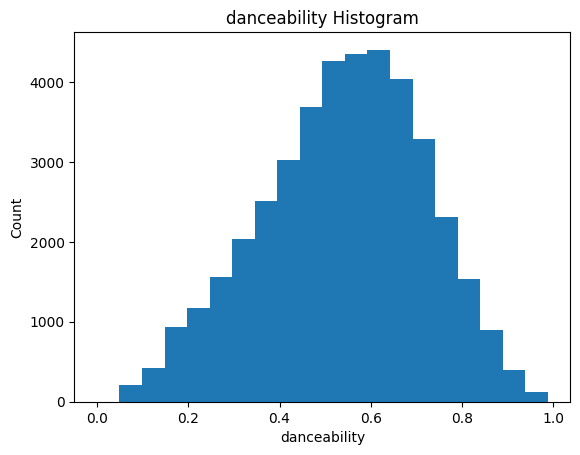

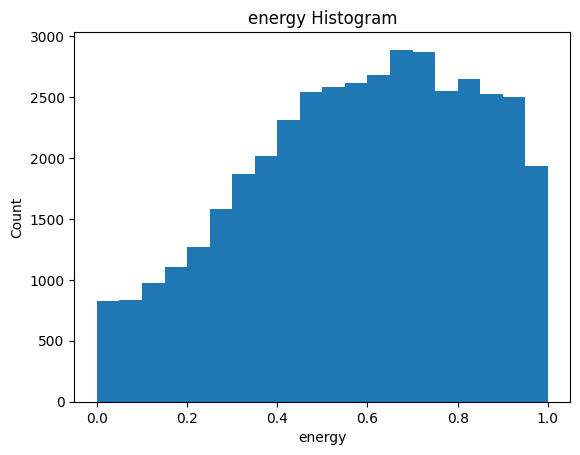

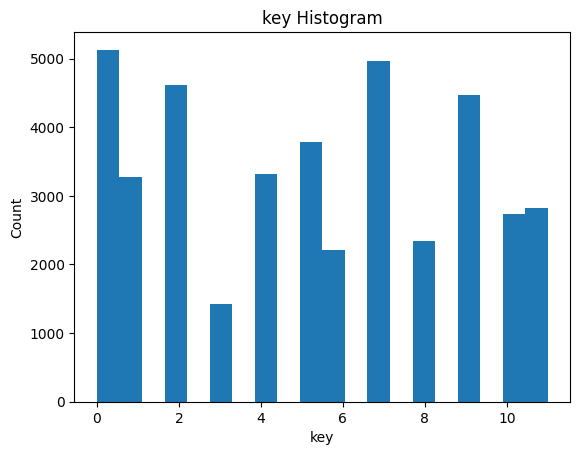

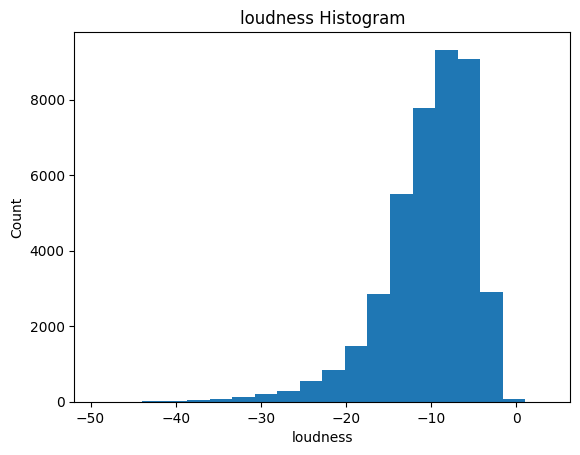

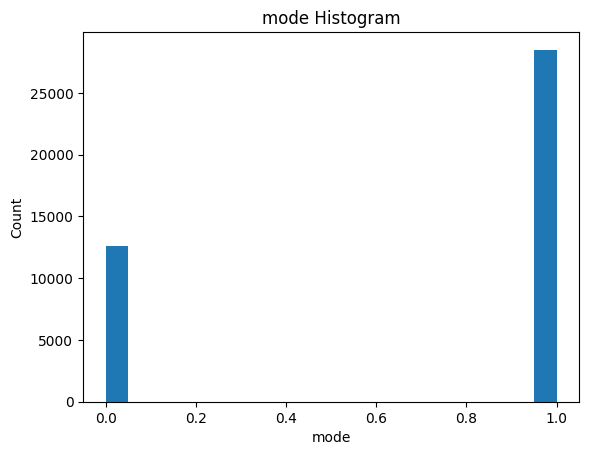

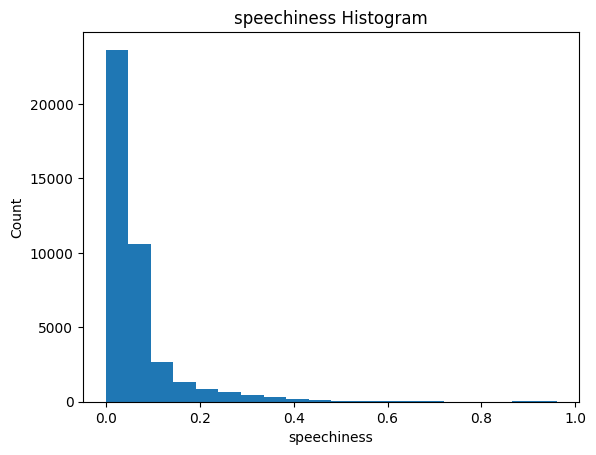

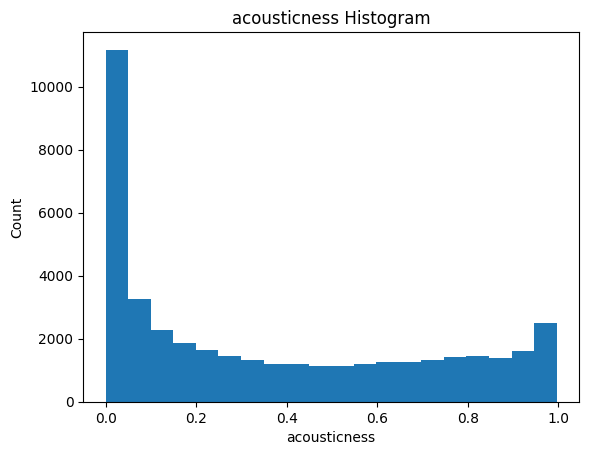

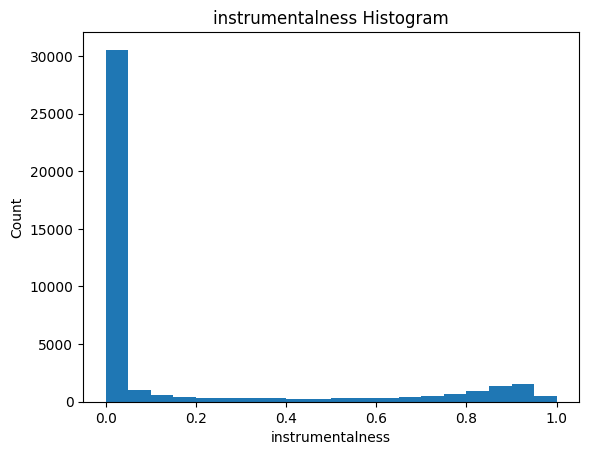

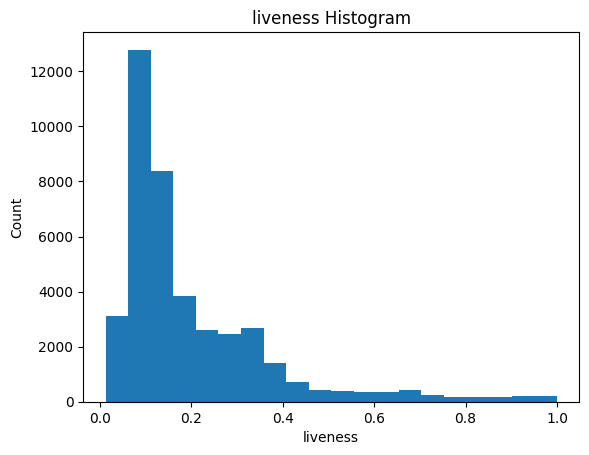

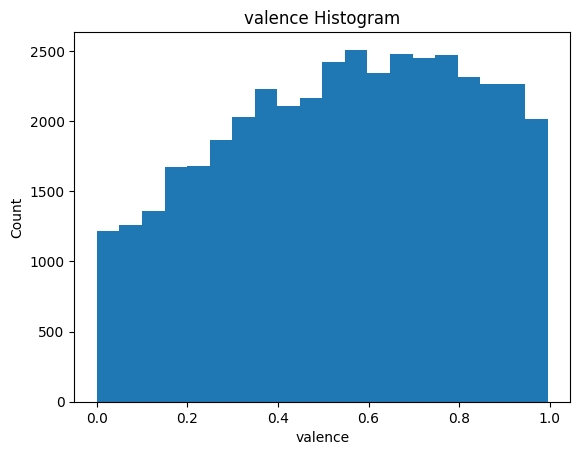

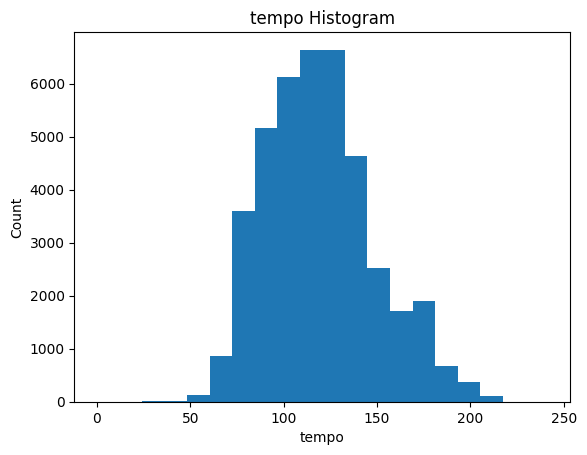

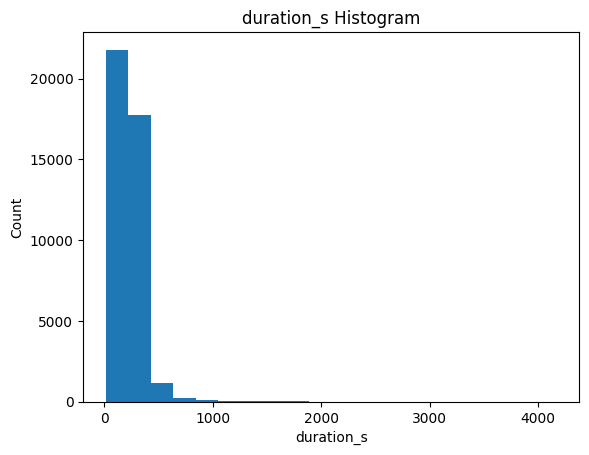

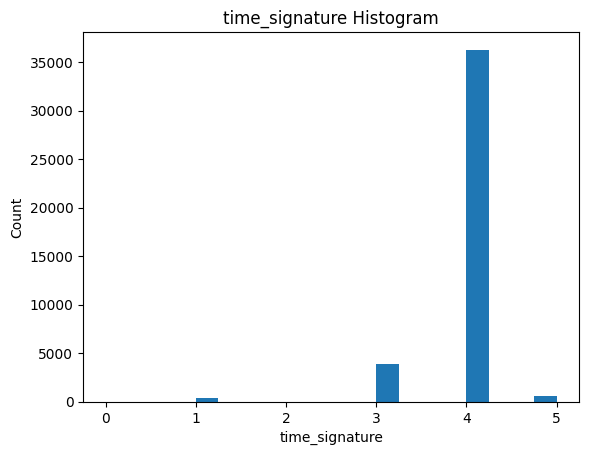

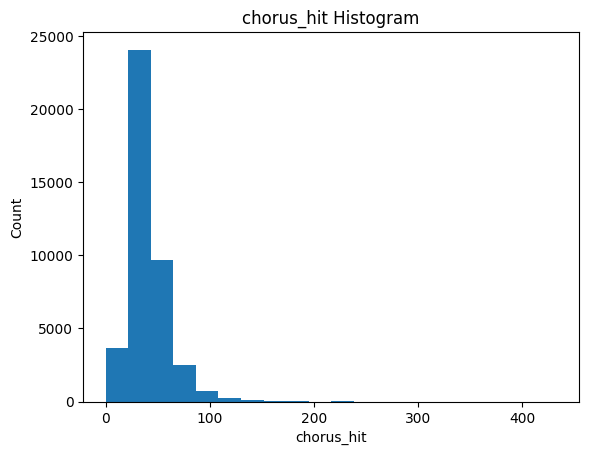

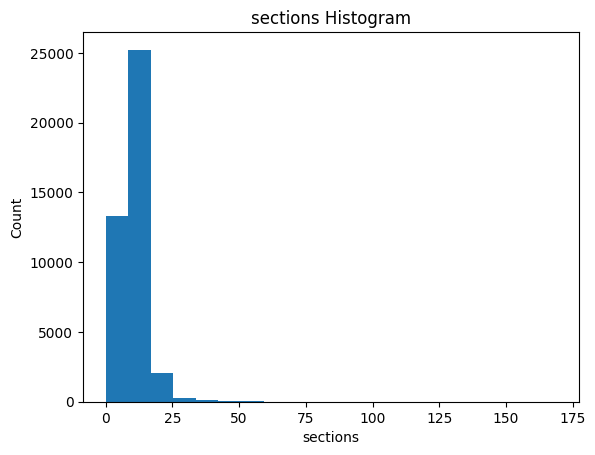

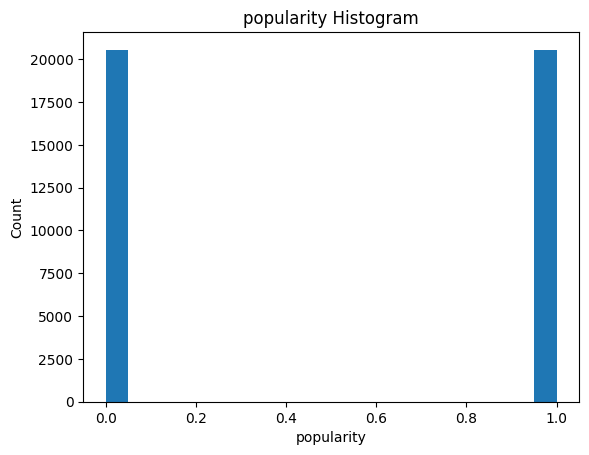

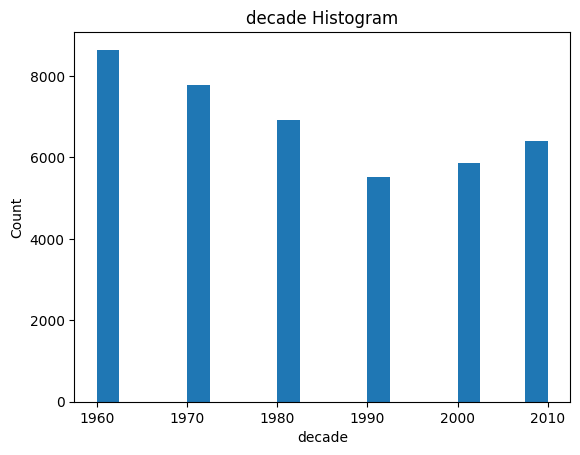

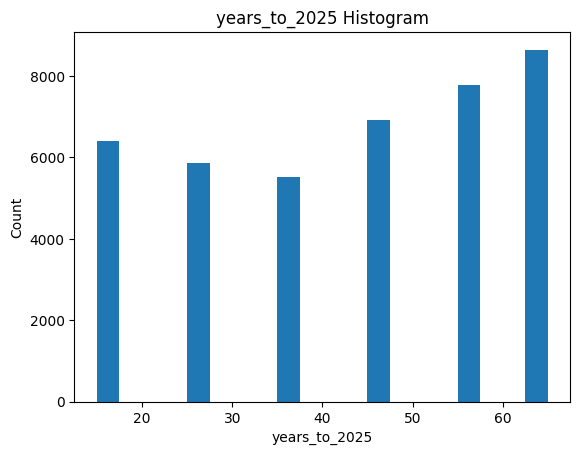

In [ ]:
# histograms loop
for feature in dataset.columns:
    if pd.api.types.is_numeric_dtype(dataset[feature]):
        dataset[feature].hist(bins=20)
        plt.xlabel(feature)
        plt.ylabel("Count")
        plt.title(f"{feature} Histogram")
        plt.grid(False)
        plt.show()

**Figs. 1.1-1.18:**

The above figures represent histograms of the variables 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_s', 'time_signature', 'chorus_hit', 'sections', 'popularity', 'decade', and 'years_to_2025', respectively, showing their various distributions.

genre
pop      16460
r&b      11040
rock      6850
latin     2870
rap       2364
edm       1515
Name: count, dtype: int64


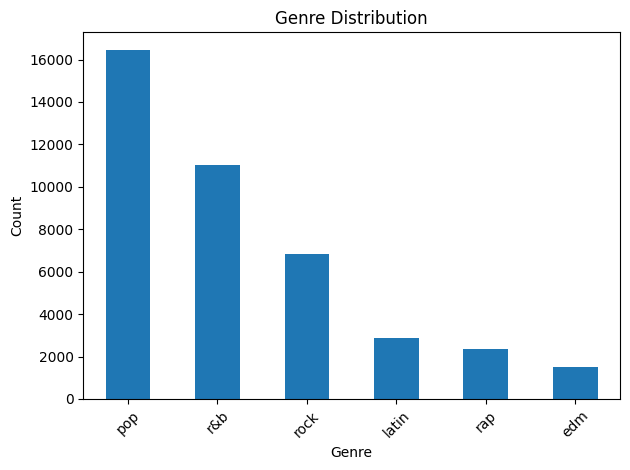

In [ ]:
# genres bar plot
print(dataset['genre'].value_counts())
dataset['genre'].value_counts().plot(kind = 'bar')
plt.title("Genre Distribution")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

**Fig. 1.19:**

The above figure represents the various counts for each of the six genres present in our dataset. It demonstrates that pop dominates the dataset and shows the imbalance in that variable.

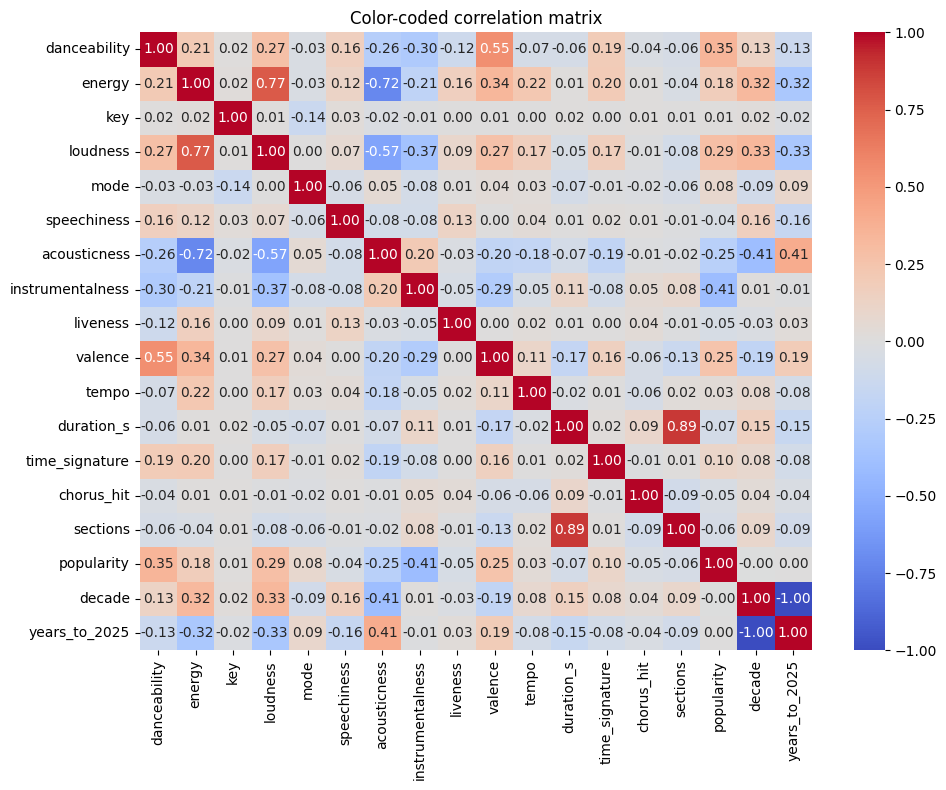

In [ ]:
# correlation matrix
plt.figure(figsize = (10, 8))
sns.heatmap(dataset.drop(["track", "artist", "genre"], axis = 1).corr(), annot = True,
            fmt = ".2f", cmap = "coolwarm", center = 0)
plt.title("Color-coded correlation matrix")
plt.tight_layout()
plt.show()

**Fig. 1.20:**

The above figure is a correlation matrix of all variables with each other. Notably, 'duration_s' and 'sections' are very highly correlated. So are 'decade' and 'years_to_2025', but this is expected since the former created the latter. We plan on dropping 'sections' and 'decade'.

Potential variables with multicollinearity include ‘sections’ and ‘duration_s’, which had a correlation of 0.89. This makes sense, as longer songs are more likely to have more sections than shorter songs. ‘Loudness’ and ‘energy’ are also somewhat correlated with a score of 0.77. Energetic tracks are described as “fast, loud, and noisy” in the data documentation, so it makes sense that louder tracks will have more energy and vice versa. Valence and danceability have a correlation of 0.55. Since valence describes how “happy” music tends to have traits that coincide with danceability, such as “rhythm stability, beat strength, and overall regularity” according to the data documentation. Other than these pairings, which we'll deal with by dropping columns (mentioned above) the variables do not seem to exhibit much collinearity.


## Section 2: Preprocessing

### Section 2.1: Missingness

As seen here, unlike in the previous dataset for Milestone 2, this dataset has absolutely no missing data. Hurray!

In [ ]:
# checking for missingness in the data
dataset.isnull().sum()

,0
track,0
artist,0
danceability,0
energy,0
key,0
loudness,0
mode,0
speechiness,0
acousticness,0
instrumentalness,0


### Section 2.2: Class Imbalance

The class imbalance between success/not success (0 or 1 in "popularity") is only 3 more in the latter category than the former. In "decade", each decade is also between 13-20%, which is roughly even. For that reason, these both will be left as-is.

Genre shows the most discrepancy. We could undersample "pop" to make this more even, but since pop is often very overrepresented in music in general, no actions were taken for this either.

In [ ]:
# write function to check class imbalances
def check_class_imbalance(df, column_name):
    counts = df[column_name].value_counts()
    percentages = df[column_name].value_counts(normalize=True) * 100
    imbalance_df = pd.DataFrame({'Count': counts, 'Percentage': percentages})
    return imbalance_df

In [ ]:
# 01: popularity
popularity_imbalance_diagnostic = check_class_imbalance(dataset, 'popularity')
print(popularity_imbalance_diagnostic)

# 02: genre
genre_imbalance_diagnostic = check_class_imbalance(dataset, 'genre')
print(genre_imbalance_diagnostic)

# 03: decade
decade_imbalance_diagnostic = check_class_imbalance(dataset, 'decade')
print(decade_imbalance_diagnostic)

            Count  Percentage
popularity                   
0           20551    50.00365
1           20548    49.99635
       Count  Percentage
genre                   
pop    16460   40.049636
r&b    11040   26.861967
rock    6850   16.667072
latin   2870    6.983138
rap     2364    5.751965
edm     1515    3.686221
        Count  Percentage
decade                   
1960     8642   21.027276
1970     7764   18.890971
1980     6907   16.805762
2010     6396   15.562422
2000     5871   14.285019
1990     5519   13.428551


### Section 2.3: Encoding

Performed in same way as in Milestone 2!

In [ ]:
# use sine and cosine processing since the key in music theory
# contains a cyclic nature which helps for the model to understand
dataset['key_sin'] = np.sin(2 * np.pi * dataset['key'] / 12)
dataset['key_cos'] = np.cos(2 * np.pi * dataset['key'] / 12)

# one-hot encode time signature
dataset = pd.get_dummies(dataset, columns = ['time_signature'], drop_first=True)
dataset

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,popularity,decade,genre,years_to_2025,key_sin,key_cos,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,Jealous Kind Of Fella,Garland Green,0.417,0.620,3,-7.727,1,0.0403,0.4900,0.000000,...,1,1960,edm,65,1.000000,6.123234e-17,False,True,False,False
1,Initials B.B.,Serge Gainsbourg,0.498,0.505,3,-12.475,1,0.0337,0.0180,0.107000,...,0,1960,pop,65,1.000000,6.123234e-17,False,False,True,False
2,Melody Twist,Lord Melody,0.657,0.649,5,-13.392,1,0.0380,0.8460,0.000004,...,0,1960,pop,65,0.500000,-8.660254e-01,False,False,True,False
3,Mi Bomba Sonó,Celia Cruz,0.590,0.545,7,-12.058,0,0.1040,0.7060,0.024600,...,0,1960,pop,65,-0.500000,-8.660254e-01,False,False,True,False
4,Uravu Solla,P. Susheela,0.515,0.765,11,-3.515,0,0.1240,0.8570,0.000872,...,0,1960,r&b,65,-0.500000,8.660254e-01,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41094,Lotus Flowers,Yolta,0.172,0.358,9,-14.430,1,0.0342,0.8860,0.966000,...,0,2010,rock,15,-1.000000,-1.836970e-16,False,False,True,False
41095,Calling My Spirit,Kodak Black,0.910,0.366,1,-9.954,1,0.0941,0.0996,0.000000,...,1,2010,pop,15,0.500000,8.660254e-01,False,False,True,False
41096,Teenage Dream,Katy Perry,0.719,0.804,10,-4.581,1,0.0355,0.0132,0.000003,...,1,2010,pop,15,-0.866025,5.000000e-01,False,False,True,False
41097,Stormy Weather,Oscar Peterson,0.600,0.177,7,-16.070,1,0.0561,0.9890,0.868000,...,0,2010,pop,15,-0.500000,-8.660254e-01,False,False,True,False


### Section 2.4: Scaling

The scaling here is applied in the same way as it was in Milestone 2, simply with the new final dataset.

In [ ]:
# copy before continuing to preserve history
dataset = dataset.copy()

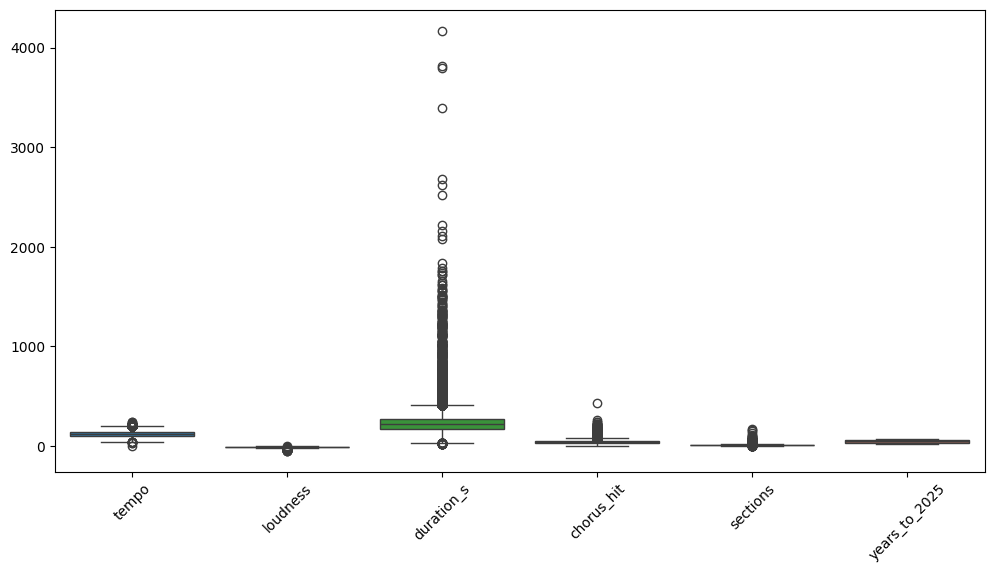

In [ ]:
# needed imports for the boxplot
import seaborn as sns
import matplotlib.pyplot as plt

# creating a boxplot to see if outliers are present
plt.figure(figsize=(12, 6))
sns.boxplot(data = dataset[['tempo', 'loudness', 'duration_s', 'chorus_hit', 'sections', 'years_to_2025']])
plt.xticks(rotation=45)
plt.show()

**Fig. 2.1:**

The above figure is a box plot of the variables which were not between 0 and 1, to see their range and determine what type of scaler should be applied.

In [ ]:
# dropping out key column (since we re-encoded it with sin/cos)
dataset = dataset.drop(columns=['key'])

In [ ]:
from sklearn.preprocessing import RobustScaler

In [ ]:
# calling robust scaler on the high-outlier variables like duration, energy_proxy
robust_scaler = RobustScaler()
dataset[['tempo', 'loudness', 'duration_s', 'chorus_hit', 'sections', 'years_to_2025']] = robust_scaler.fit_transform(
    dataset[['tempo', 'loudness', 'duration_s', 'chorus_hit', 'sections', 'years_to_2025']])

# one-hot encoding type transform
one_hot_cols = ['time_signature_1', 'time_signature_3', 'time_signature_4', 'time_signature_5']
dataset[one_hot_cols] = dataset[one_hot_cols].astype(int)

# another copy for dataframe history preservation
dataset_cleaned_preprocessed = dataset.copy()
dataset_cleaned_preprocessed

,track,artist,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,popularity,decade,genre,years_to_2025,key_sin,key_cos,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,Jealous Kind Of Fella,Garland Green,0.417,0.620,0.237522,1,0.0403,0.4900,0.000000,0.0779,...,1,1960,edm,0.666667,1.000000,6.123234e-17,0,1,0,0
1,Initials B.B.,Serge Gainsbourg,0.498,0.505,-0.499573,1,0.0337,0.0180,0.107000,0.1760,...,0,1960,pop,0.666667,1.000000,6.123234e-17,0,0,1,0
2,Melody Twist,Lord Melody,0.657,0.649,-0.641931,1,0.0380,0.8460,0.000004,0.1190,...,0,1960,pop,0.666667,0.500000,-8.660254e-01,0,0,1,0
3,Mi Bomba Sonó,Celia Cruz,0.590,0.545,-0.434837,0,0.1040,0.7060,0.024600,0.0610,...,0,1960,pop,0.666667,-0.500000,-8.660254e-01,0,0,1,0
4,Uravu Solla,P. Susheela,0.515,0.765,0.891407,0,0.1240,0.8570,0.000872,0.2130,...,0,1960,r&b,0.666667,-0.500000,8.660254e-01,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41094,Lotus Flowers,Yolta,0.172,0.358,-0.803074,1,0.0342,0.8860,0.966000,0.3140,...,0,2010,rock,-1.000000,-1.000000,-1.836970e-16,0,0,1,0
41095,Calling My Spirit,Kodak Black,0.910,0.366,-0.108205,1,0.0941,0.0996,0.000000,0.2610,...,1,2010,pop,-1.000000,0.500000,8.660254e-01,0,0,1,0
41096,Teenage Dream,Katy Perry,0.719,0.804,0.725918,1,0.0355,0.0132,0.000003,0.1390,...,1,2010,pop,-1.000000,-0.866025,5.000000e-01,0,0,1,0
41097,Stormy Weather,Oscar Peterson,0.600,0.177,-1.057673,1,0.0561,0.9890,0.868000,0.1490,...,0,2010,pop,-1.000000,-0.500000,-8.660254e-01,0,0,1,0


In [ ]:
# final info check!
dataset_cleaned_preprocessed.info()
dataset_cleaned_preprocessed.describe().T.round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41099 entries, 0 to 41098
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track             41099 non-null  object 
 1   artist            41099 non-null  object 
 2   danceability      41099 non-null  float64
 3   energy            41099 non-null  float64
 4   loudness          41099 non-null  float64
 5   mode              41099 non-null  int64  
 6   speechiness       41099 non-null  float64
 7   acousticness      41099 non-null  float64
 8   instrumentalness  41099 non-null  float64
 9   liveness          41099 non-null  float64
 10  valence           41099 non-null  float64
 11  tempo             41099 non-null  float64
 12  duration_s        41099 non-null  float64
 13  chorus_hit        41099 non-null  float64
 14  sections          41099 non-null  float64
 15  popularity        41099 non-null  int64  
 16  decade            41099 non-null  int64 

,count,mean,std,min,25%,50%,75%,max
danceability,41099.0,0.54,0.18,0.00,0.42,0.55,0.67,0.99
energy,41099.0,0.58,0.25,0.00,0.40,0.60,0.79,1.00
loudness,41099.0,-0.15,0.82,-6.21,-0.55,0.00,0.45,2.02
mode,41099.0,0.69,0.46,0.00,0.00,1.00,1.00,1.00
speechiness,41099.0,0.07,0.09,0.00,0.03,0.04,0.07,0.96
acousticness,41099.0,0.36,0.34,0.00,0.04,0.26,0.68,1.00
instrumentalness,41099.0,0.15,0.30,0.00,0.00,0.00,0.06,1.00
liveness,41099.0,0.20,0.17,0.01,0.09,0.13,0.26,1.00
valence,41099.0,0.54,0.27,0.00,0.33,0.56,0.77,1.00
tempo,41099.0,0.05,0.74,-3.01,-0.52,0.00,0.48,3.17


### Section 2.5: Feature Importance

A random forest model was fitted on the data in order to get a view on feature importance. The code below generated the feature importance graph for the full dataset "all", but the image for "lim" is also included here for completeness' sake.

Note: *The below code is example code and does not need to be run.*

In [ ]:
#from sklearn.ensemble import RandomForestClassifier

# random forest model
#rf_model_all = RandomForestClassifier().fit(X_train_all, y_train_all)
#importances_all = rf_model_all.feature_importances_

# make indices, sort features by importance
#indices_all = np.argsort(importances_all)[::-1]
#feature_names_all = ["danceability", "energy", "loudness", "mode", "speechiness",
       #"acousticness", "instrumentalness", "liveness", "valence", "tempo",
       #"duration_s", "years_to_2025", "key_sin", "key_cos", "time_signature_1",
       #"time_signature_3", "time_signature_4", "time_signature_5", "genre_edm",
       #"genre_latin", "genre_pop", "genre_r&b", "genre_rap", "genre_rock"]

# plot
#plt.figure(figsize = (8, 6))
#plt.barh(range(len(importances_all)), importances_all[indices_all], align = 'center', color = "skyblue")
#plt.yticks(range(len(importances_all)), np.array(feature_names_all)[indices_all])
#plt.xlabel('Importance Score')
#plt.title('Feature Importance from Random Forest ("all")')
#plt.gca().invert_yaxis()
#plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 109B Feature Importance (all).png to 109B Feature Importance (all).png


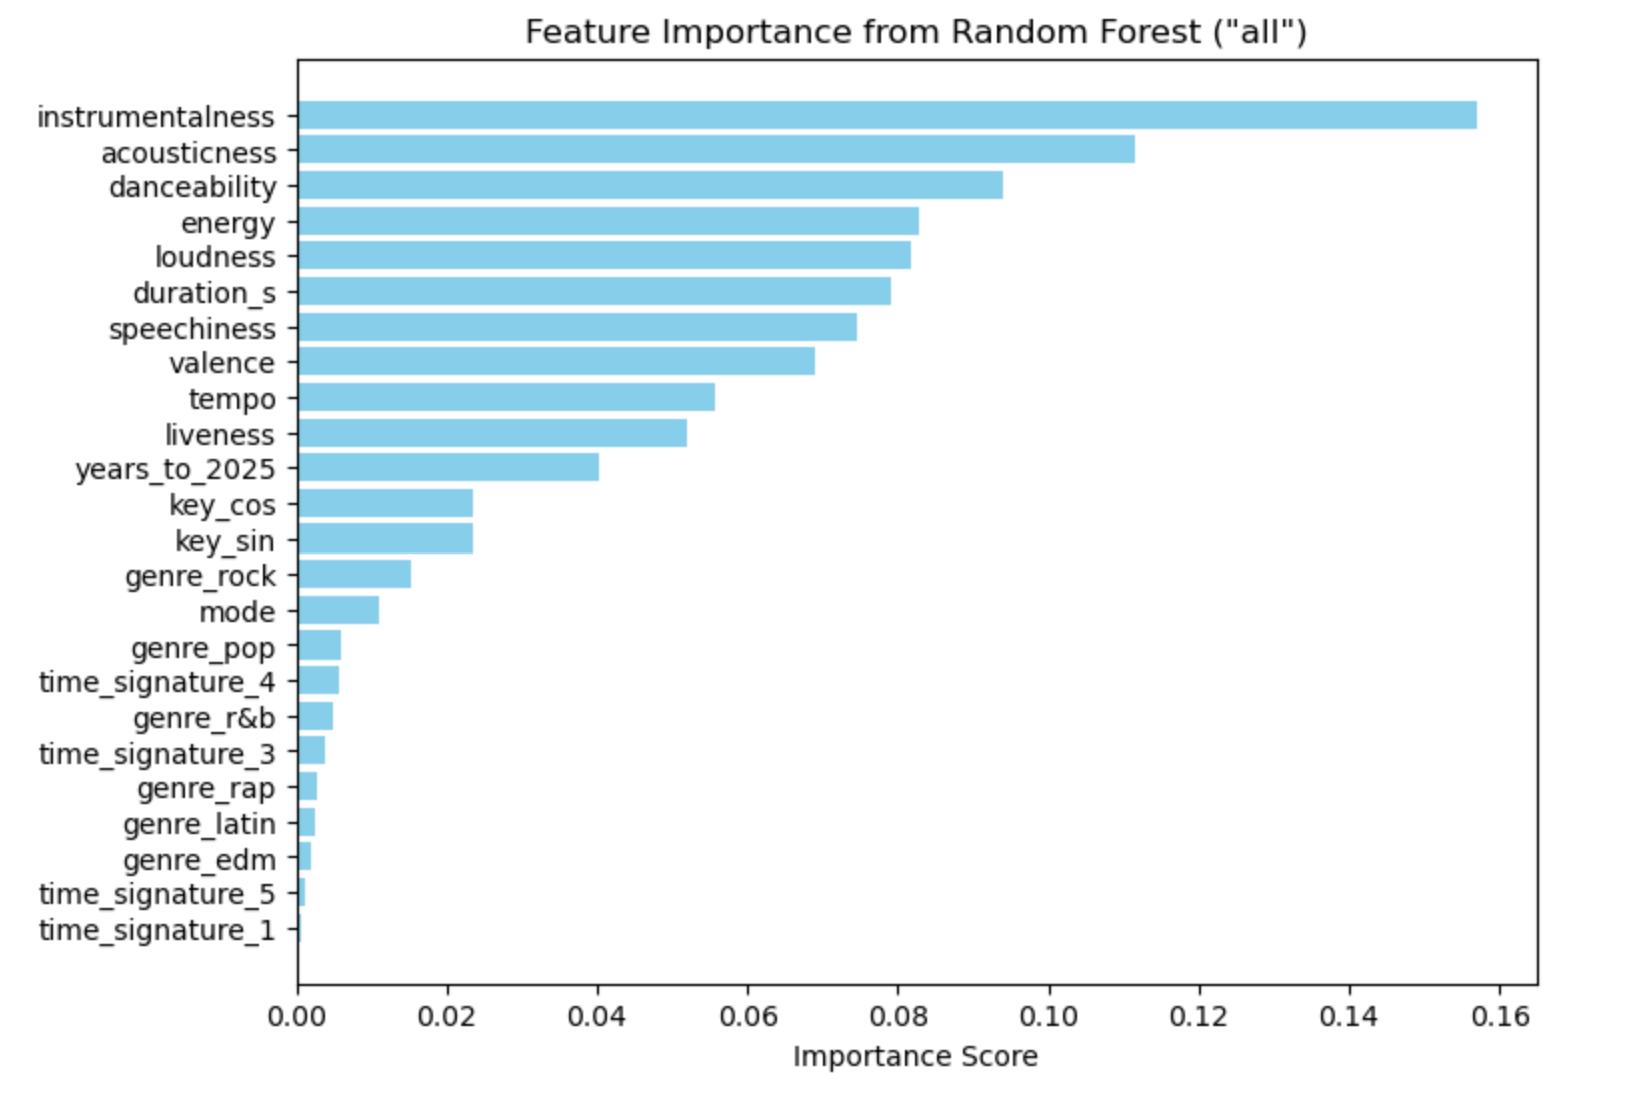

In [ ]:
from IPython.display import Image
Image("109B Feature Importance (all).png")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 109B Feature Importance (lim).png to 109B Feature Importance (lim).png


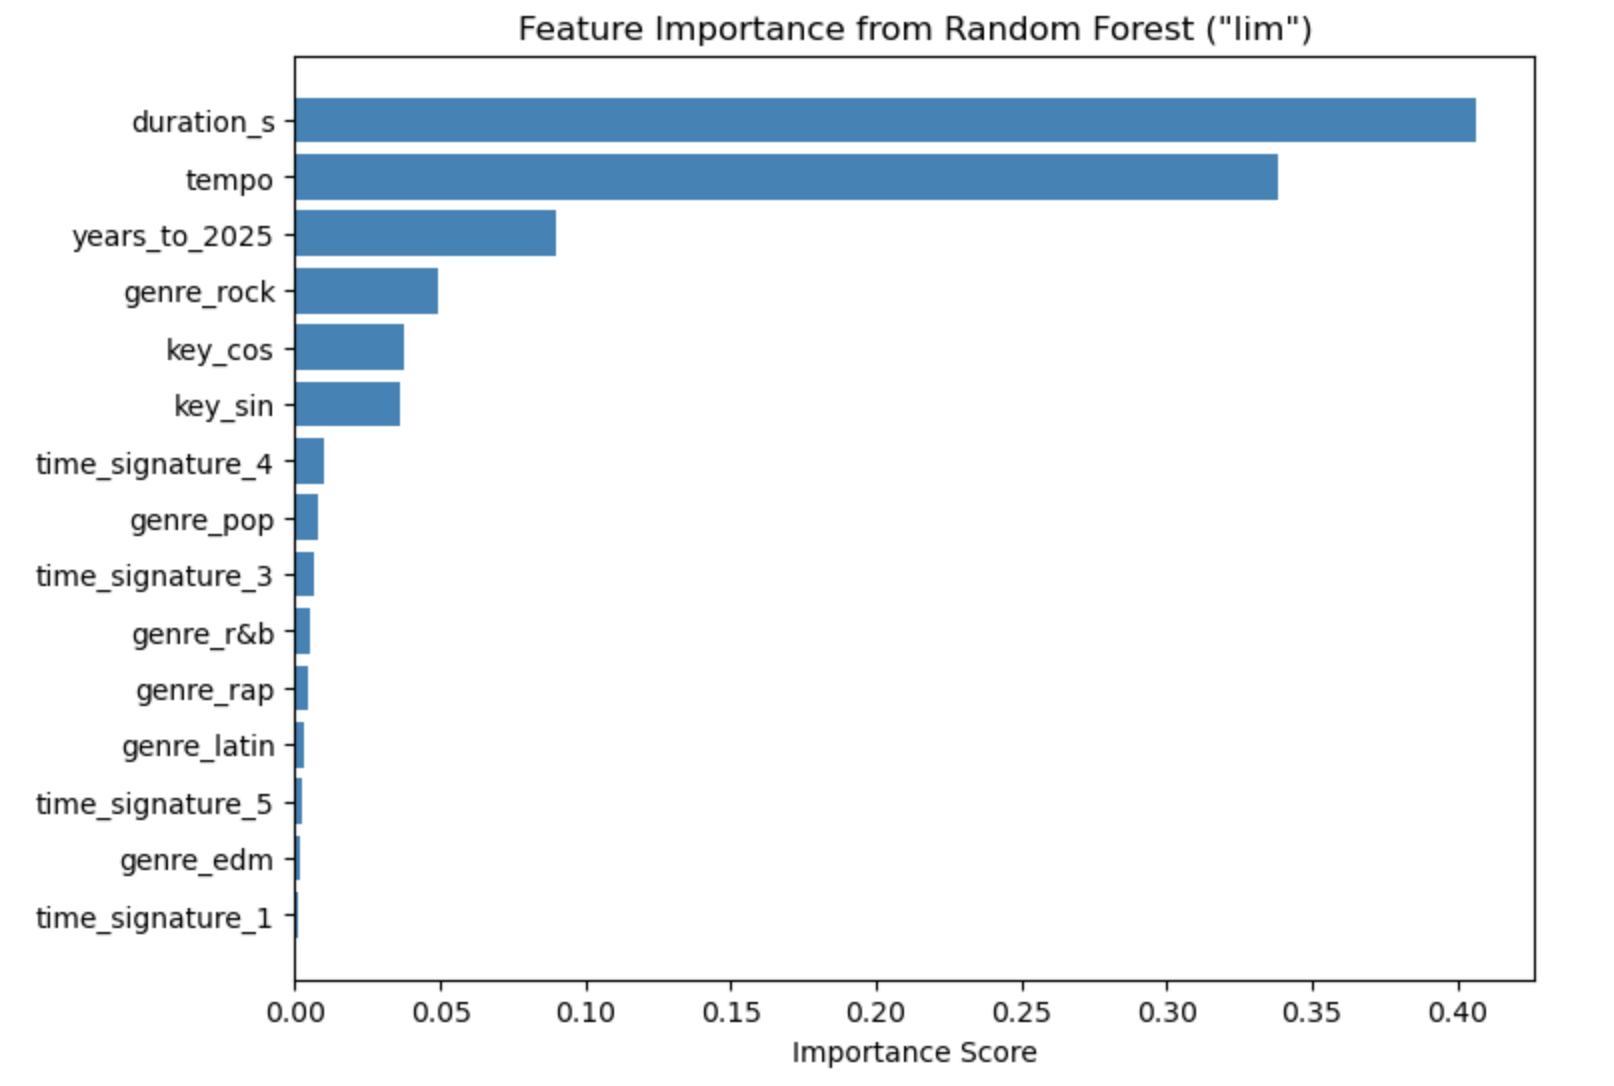

In [ ]:
from IPython.display import Image
Image("109B Feature Importance (lim).png")

**Fig 2.2-2.3:**

The above figures are a feature importance plot for the full model with all variables, as well as the limited model without the Spotify API variables, generated from a random forest model.

### Section 2.6: Review Summary (EDA)

After switching datasets based on the challenges faced during Milestone 2 and following our TF’s advice, we utilized the Spotify Hit Predictor Dataset. This dataset covers songs from 1960 to 2019, and each observation represents a different song. The target variable is 'popularity', which indicates whether a song was a “hit” (appearing on the Billboard Hot-100) or a “flop.” To gain further insight on genre, we utilized a merged version of this dataset from Kaggle that included web-scraped genre information, adding ‘genre’ as an additional variable.

The merged dataset has 41,099 observations across 20 columns. The features include danceability, energy, key, loudness, mode (major or minor scale), speechiness, acousticness, instrumentalness, liveness, tempo, duration (in seconds), time signature, chorus hit (timestamp of when the chorus starts), sections, and the target variable popularity. Track title, artist, genre, and decade are categorical variables. We utilized one-hot-encoding for genre and time_signature. To transform the decade predictor into a numeric feature, we defined a variable years_to_2025 that subtracts the decade variable from 2025. Furthermore, due to the cyclical nature of musical keys, we transformed 'key' into sine and cosine components.

When reviewing descriptive statistics, we observed that the mean song duration was about 235 seconds (~4 minutes), although the maximum value suggested extreme outliers, supporting our decision to standardize this feature. The average tempo of our dataset was 119 BPM, which is a common mid-tempo range in pop music. Additionally, about 69% of songs were in a major key, suggesting that upbeat tones are more common among the dataset. In revisiting genre and decade, we found that pop, R&B, and rock dominated the dataset, while other genres like rap, EDM, and Latin music were underrepresented. Since genre is a predictor rather than the target variable, this imbalance does not inherently bias the model. Decade also appeared relevant, as earlier songs tended to have higher valence, suggesting they were perceived as more positive.

Our histograms revealed that danceability, tempo, loudness, and liveness appeared roughly normally distributed, with slight skews in tempo (right skew), liveness (right skew), and loudness (left skew). Features like speechiness, acousticness, and instrumentalness were heavily concentrated at zero, meaning there was little variability among songs for these traits. Notably, most tracks were studio-produced (low liveness) rather than live performances.

From our correlation heatmap, we saw that valence was positively correlated with popularity, suggesting that more positive songs tend to chart better. Valence was negatively correlated with decade, indicating that older songs were, on average, more positive. Energy and acousticness were strongly negatively correlated, consistent with the idea that energetic songs tend to be less acoustic. Duration and sections were almost perfectly correlated, meaning that longer songs naturally had more sections like verses and choruses. This led us to decide to drop 'sections' from the dataset due to multicollinearity.

We also organized our predictors into two different feature sets: one that only used "pre-release" features (e.g., tempo, duration, time signature, key, decade, genre) and one that included all features (including Spotify API-engineered fields like valence and danceability). This allowed us to test how much predictive power comes from basic song characteristics alone versus more complex Spotify-derived features.

Finally, our EDA revealed preliminary insights into feature importance. Danceability and instrumentalness showed the strongest linear correlations with popularity, with danceability positively associated and instrumentalness negatively associated. This suggests that songs that are danceable and have vocals are more likely to be successful. This was supported by the results of the random-forest-based feature importance, where 'instrumentalness', 'acousticness', and 'danceability' registered as the most important features.


## Section 3: Baseline Model

### Section 3.1: Research Question

Our revised research question/objective for this project has two different parts:

01: Can we correctly predict whether a song is a success or not based on its musical features?

02: What specific features of a song are most strongly associated with a song’s success? How might this have changed over various decades?


### Section 3.2: Prepping the Dataset

Here, we needed to encode genre to be able to be input into our baseline model. Other categoricals that are unique to each song, like "track" and "artist" were dropped as they are not useful predictors for our research questions. The target variable, "popularity", was also separated.

Additionally, the columns "sections" and "chorus_hit" were dropped. "sections" was dropped due to being highly correlated with another variable in the EDA results. "chorus_hit" was dropped as we did not have it available in our "new_songs" final test file (see this in section 4.2) and so did not want to use it to train the model.

Finally and most importantly, two copies of X were generated, "X_all", which contains all features after dropping out the mentioned columns above, and "X_lim", which contains only those features which were not creations of the Spotify API (to see if raw musical data alone can correctly predict success/not success).

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# one-hot-encode genres
genre_encoder = OneHotEncoder(sparse_output=False)
genre_encoded = genre_encoder.fit_transform(dataset_cleaned_preprocessed[['genre']])
genre_encoded_df = pd.DataFrame(genre_encoded, columns=genre_encoder.get_feature_names_out(['genre']))
dataset_cleaned_preprocessed = pd.concat([dataset_cleaned_preprocessed.reset_index(drop=True), genre_encoded_df], axis=1)

num_genres = len(genre_encoded_df.columns)


In [ ]:
# making copy without certain columns (strings)
# eliminate: track, artist, decade, genre (since we're using years_to_2025)
# set outcome
y = dataset_cleaned_preprocessed['popularity']

# make first predictor matrix
X_all = dataset_cleaned_preprocessed.drop(columns = ['track', 'artist', 'decade', 'genre', 'popularity', 'sections', 'chorus_hit'])

print(X_all.columns)
X_all.head()

Index(['danceability', 'energy', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_s', 'years_to_2025', 'key_sin', 'key_cos', 'time_signature_1',
       'time_signature_3', 'time_signature_4', 'time_signature_5', 'genre_edm',
       'genre_latin', 'genre_pop', 'genre_r&b', 'genre_rap', 'genre_rock'],
      dtype='object')


,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,...,time_signature_1,time_signature_3,time_signature_4,time_signature_5,genre_edm,genre_latin,genre_pop,genre_r&b,genre_rap,genre_rock
0,0.417,0.620,0.237522,1,0.0403,0.490,0.000000,0.0779,0.845,1.741614,...,0,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.498,0.505,-0.499573,1,0.0337,0.018,0.107000,0.1760,0.797,-0.403182,...,0,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.657,0.649,-0.641931,1,0.0380,0.846,0.000004,0.1190,0.908,-0.041538,...,0,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.590,0.545,-0.434837,0,0.1040,0.706,0.024600,0.0610,0.967,-0.306217,...,0,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.515,0.765,0.891407,0,0.1240,0.857,0.000872,0.2130,0.906,-0.075378,...,0,0,1,0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# making copy with only pre-released features
pre_release_features = ["key_cos", "key_sin", "tempo", "duration_s", "years_to_2025",
                        "time_signature_1", "time_signature_3",
                        "time_signature_4", "time_signature_5"] + genre_encoded_df.columns.tolist()
X_lim = X_all[pre_release_features].copy()
print(X_lim.columns)
X_lim.head()

Index(['key_cos', 'key_sin', 'tempo', 'duration_s', 'years_to_2025',
       'time_signature_1', 'time_signature_3', 'time_signature_4',
       'time_signature_5', 'genre_edm', 'genre_latin', 'genre_pop',
       'genre_r&b', 'genre_rap', 'genre_rock'],
      dtype='object')


,key_cos,key_sin,tempo,duration_s,years_to_2025,time_signature_1,time_signature_3,time_signature_4,time_signature_5,genre_edm,genre_latin,genre_pop,genre_r&b,genre_rap,genre_rock
0,6.123234e-17,1.0,1.741614,-0.472786,0.666667,0,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0
1,6.123234e-17,1.0,-0.403182,-0.045751,0.666667,0,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0
2,-8.660254e-01,0.5,-0.041538,0.064492,0.666667,0,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0
3,-8.660254e-01,-0.5,-0.306217,-0.639274,0.666667,0,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0
4,8.660254e-01,-0.5,-0.075378,0.295057,0.666667,0,0,1,0,0.0,0.0,0.0,1.0,0.0,0.0


### Section 3.3: Baseline Model Construction and Fitting

This section forms the construction of our baseline models. We chose our patience, early stopping, and optimizer to align with what was typically used in class for a fully connected neural network. We also wanted a simpler model, so we opted for only four dense layers. Since our popularity predictor is only 0 or 1, a binary, we would use the sigmoid as our output activation, and use binary cross entropy as our loss function.

There are two models, one for the pre-release features only (not dependent on Spotify), and one for all features, to enable comparisons between the two (see writeup for more information).

---

*Note: Generative AI was used to mock-up the model with prompt:*

"Baseline model is a fully connected neural network, preferably as simple as possible, binary cross entropy loss, sigmoid output.
Start with four dense layers, tweak based off of performance.
Train-test split (80/20).
Optimize with Adam, patience = 5 (early stopping).
Genre is one-hot encoded."

The model was then prompted to become a function so that num_numeric_features could be different depending on if we were using the "pre-release features" only, or all of them. It was also used for debugging, and for making the plotting function.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 109B Baseline Model Flowchart.png to 109B Baseline Model Flowchart.png


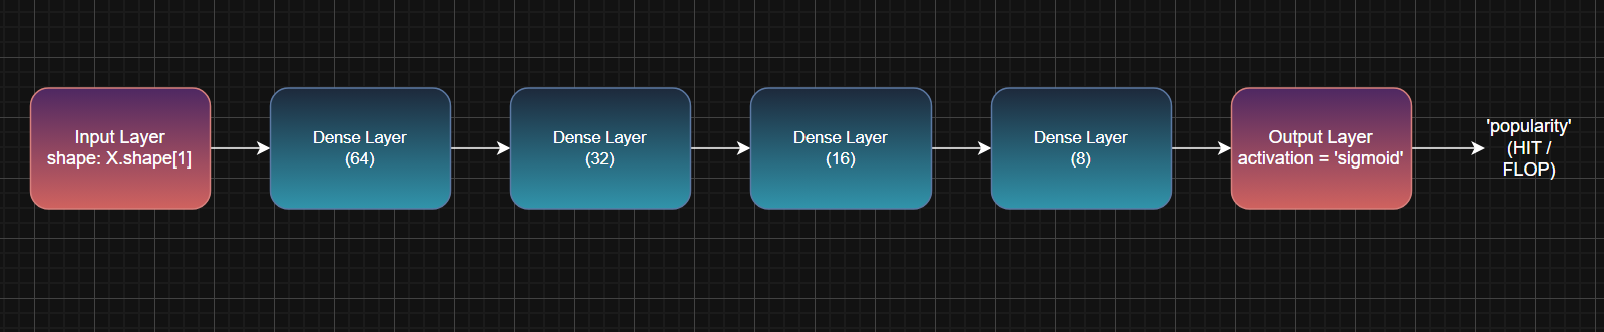

In [ ]:
from IPython.display import Image
Image("109B Baseline Model Flowchart.png")

**Fig 3.1:**

Flowchart representing the structure of the baseline model.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [ ]:
# function developing the model architecture
def build_baseline_model(num_features):
    numeric_input = Input(shape=(num_features,), name='numeric_input')

    x = numeric_input
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(8, activation='relu')(x)

    output = Dense(1, activation='sigmoid')(x)

    baseline_model = Model(inputs=numeric_input, outputs=output)
    return baseline_model

In [ ]:
# set num_numeric_features
num_features_all = X_all.shape[1]
num_features_lim = X_lim.shape[1]

In [ ]:
# model calls
baseline_model_all = build_baseline_model(num_features_all)
baseline_model_lim = build_baseline_model(num_features_lim)

In [ ]:
# model summaries
baseline_model_all.summary()
baseline_model_lim.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ numeric_input (InputLayer)      │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353 (17.00 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ numeric_input (InputLayer)      │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,777 (14.75 KB)

 Trainable params: 3,777 (14.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# model compile

# compile both models separately
baseline_model_all.compile(optimizer = tf.keras.optimizers.Adam(),
                           loss = tf.keras.losses.BinaryCrossentropy(),
                           metrics = ['accuracy'])
baseline_model_lim.compile(optimizer = tf.keras.optimizers.Adam(),
                           loss = tf.keras.losses.BinaryCrossentropy(),
                           metrics = ['accuracy'])

In [ ]:
# early stopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [ ]:
# train-test splits
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y, test_size = 0.2, random_state = 109)
X_train_lim, X_test_lim, y_train_lim, y_test_lim = train_test_split(X_lim, y, test_size = 0.2, random_state = 109)

# withhold 10% of the training as validation set
X_train_all, X_val_all, y_train_all, y_val_all = train_test_split(X_train_all, y_train_all,
                                                                    test_size = 0.1, random_state = 109)
X_train_lim, X_val_lim, y_train_lim, y_val_lim = train_test_split(X_train_lim, y_train_lim,
                                                                    test_size = 0.1, random_state = 109)

After running the above code block, *skip* to Section 3.4 to load the baseline models' full weights and training history to save the penguins! If you don't have the weight and history files already in your Drive, you email Bettie for them/they're in the shared folder!

In [ ]:
# fit the baseline model for "all"
baseline_history_all = baseline_model_all.fit(
    X_train_all,
    y_train_all,
    validation_data = (X_val_all, y_val_all),
    epochs = 20,
    batch_size = 64,
    callbacks = [early_stop]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6656 - loss: 0.5988

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


463/463 ━━━━━━━━━━━━━━━━━━━━ 38s 80ms/step - accuracy: 0.6657 - loss: 0.5987 - val_accuracy: 0.7658 - val_loss: 0.4932
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.7632 - loss: 0.4893 - val_accuracy: 0.7755 - val_loss: 0.4757
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - accuracy: 0.7720 - loss: 0.4726 - val_accuracy: 0.7838 - val_loss: 0.4643
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 40s 66ms/step - accuracy: 0.7811 - loss: 0.4581 - val_accuracy: 0.7844 - val_loss: 0.4613
Epoch 5/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.7908 - loss: 0.4500 - val_accuracy: 0.7865 - val_loss: 0.4559
Epoch 6/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - accuracy: 0.7965 - loss: 0.4401 - val_accuracy: 0.7862 - val_loss: 0.4557
Epoch 7/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 31s 67ms/step - accuracy: 0.7935 - loss: 0.4408 - val_accuracy: 0.7789 - val_loss: 0.4635
Epoch 8/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - accuracy: 0.7952 - loss: 0.4410 - val_accurac

In [ ]:
baseline_history_lim = baseline_model_lim.fit(
    X_train_lim,
    y_train_lim,
    validation_data = (X_val_lim, y_val_lim),
    epochs = 20,
    batch_size = 64,
    callbacks = [early_stop]
)

Epoch 1/20
  2/463 ━━━━━━━━━━━━━━━━━━━━ 26s 56ms/step - accuracy: 0.4180 - loss: 0.7064 

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6124 - loss: 0.6469

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


463/463 ━━━━━━━━━━━━━━━━━━━━ 31s 67ms/step - accuracy: 0.6125 - loss: 0.6468 - val_accuracy: 0.6737 - val_loss: 0.5991
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - accuracy: 0.6877 - loss: 0.5831 - val_accuracy: 0.6946 - val_loss: 0.5797
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - accuracy: 0.7029 - loss: 0.5682 - val_accuracy: 0.6983 - val_loss: 0.5764
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 42s 71ms/step - accuracy: 0.7102 - loss: 0.5591 - val_accuracy: 0.6901 - val_loss: 0.5772
Epoch 5/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 31s 66ms/step - accuracy: 0.7034 - loss: 0.5634 - val_accuracy: 0.6919 - val_loss: 0.5802
Epoch 6/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 31s 67ms/step - accuracy: 0.7049 - loss: 0.5620 - val_accuracy: 0.6950 - val_loss: 0.5736
Epoch 7/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - accuracy: 0.7106 - loss: 0.5586 - val_accuracy: 0.6953 - val_loss: 0.5796
Epoch 8/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 31s 67ms/step - accuracy: 0.7068 - loss: 0.5599 - val_accurac

We can now save both of these models and their training histories, to save the penguins...

In [ ]:
from google.colab import drive
import pickle

# mount GDrive
drive.mount('/content/drive')

# saving baseline_all
baseline_model_all.save("/content/drive/MyDrive/baseline_model_all_full.keras")
with open("/content/drive/MyDrive/baseline_history_all.pkl", "wb") as f:
    pickle.dump(baseline_history_all.history, f)

# saving baseline_lim
baseline_model_lim.save("/content/drive/MyDrive/baseline_model_lim_full.keras")
with open("/content/drive/MyDrive/baseline_history_lim.pkl", "wb") as f:
    pickle.dump(baseline_history_lim.history, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Section 3.4: Training History Visualization

First, we can load the saved models and histories (this is where to start running the code again after skipping the bit in Section 3.3 where the models were trained!).

In [ ]:
from tensorflow import keras
import pickle

# baseline_all

# model
baseline_model_all = keras.models.load_model("/content/drive/MyDrive/baseline_model_all_full.keras")

# load saved training history
with open("/content/drive/MyDrive/baseline_history_all.pkl", "rb") as f:
    baseline_history_all = pickle.load(f)

In [ ]:
# baseline_lim

# model
baseline_model_lim = keras.models.load_model("/content/drive/MyDrive/baseline_model_lim_full.keras")

# load saved training history
with open("/content/drive/MyDrive/baseline_history_lim.pkl", "rb") as f:
    baseline_history_lim = pickle.load(f)

We can now make a plot showing the loss and accuracy for training and validation in both baseline models for analysis.

NOTE: the original function written by the team was changed here with the help of ChatGPT to make this work with pickle dictionaries as well as the regular .history file.

In [ ]:
import matplotlib.pyplot as plt

# function to plot loss and accuracy over epochs

def plot_training_history(history, metric, title_prefix = "Model"):
    # handling both .history objects and plain dicts
    if hasattr(history, "history"):
        history_dict = history.history
    else:
        history_dict = history

    epochs = range(1, len(history_dict['loss']) + 1)

    # subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # --- Loss ---
    axs[0].plot(epochs, history_dict['loss'], label='Training Loss')
    axs[0].plot(epochs, history_dict['val_loss'], label='Validation Loss')
    axs[0].set_title(f"{title_prefix} Loss")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy ---
    metric_name = metric
    val_metric_name = f"val_{metric_name}"

    if metric_name in history_dict:
        axs[1].plot(epochs, history_dict[metric_name], label=f'Training {metric_name}')
        axs[1].plot(epochs, history_dict[val_metric_name], label=f'Validation {metric_name}')
        axs[1].set_title(f"{title_prefix} {metric_name}")
        axs[1].set_xlabel("Epochs")
        axs[1].set_ylabel(metric_name.upper())
        axs[1].legend()
        axs[1].grid(True)
    else:
        axs[1].set_visible(False)

    plt.tight_layout()
    plt.show()

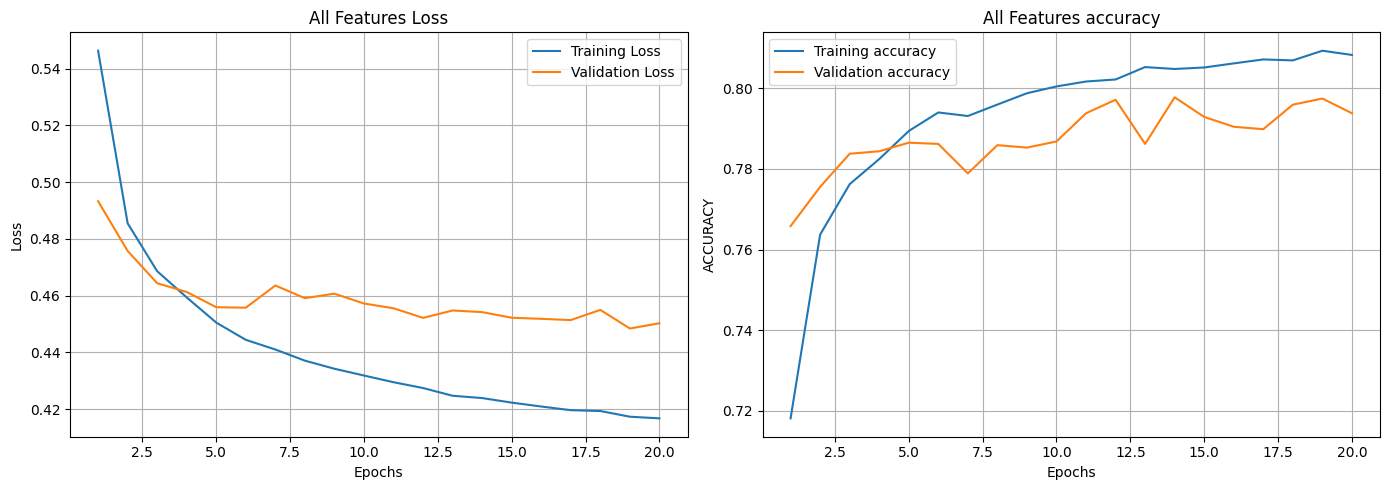

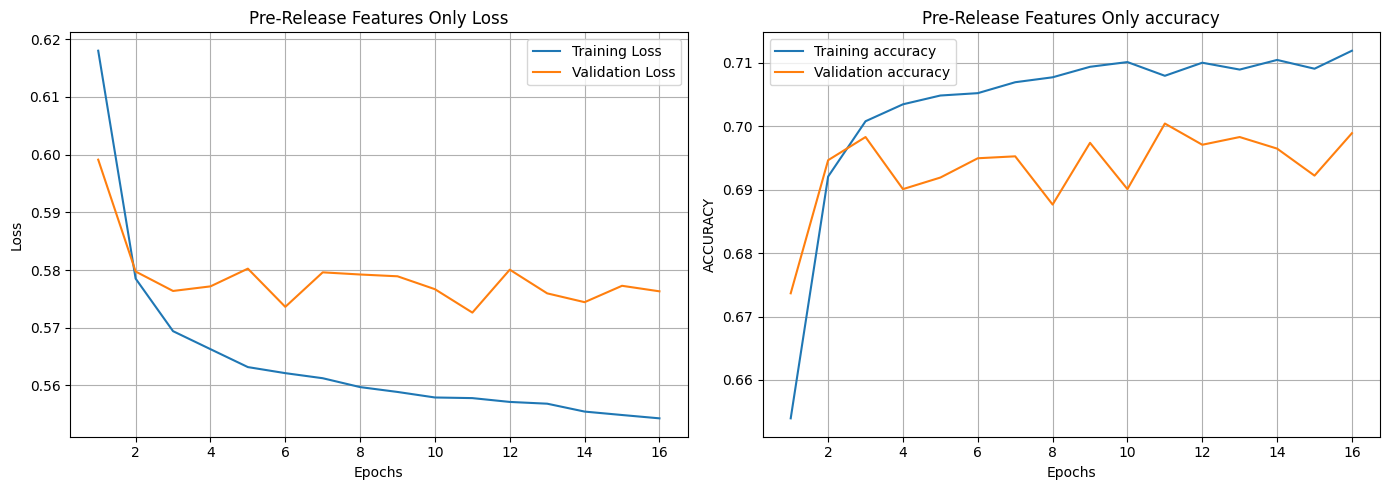

In [ ]:
# call plotting function
plot_training_history(baseline_history_all, 'accuracy', title_prefix = "All Features")
plot_training_history(baseline_history_lim, 'accuracy', title_prefix = "Pre-Release Features Only")

**Fig 3.2:**

Plots of the training vs. validation history for both accuracy and loss and on both the limited and full (all) dataset.

### Section 3.5 Baseline Model Selection and Justification

*The following is a reflection after the feedback on Milestone 3:*

Overall for our baseline model, we had initially used LabelEncoder to encode the genre and decade columns. Since receiving lots of valuable feedback, we adjusted this preprocessing step to use OneHotEncoder for the genre and a numerical variable, years_to_2025, instead. The years_to_2025 variable allows us to predict on songs written after the time of the dataset (and even hypothetical songs after 2025, if you were a songwriter hoping to craft the next hit!) Therefore, we had to remove our Embedding layers from the baseline model since one-hot encoding is not compatible with embedding layers, leaving a simple NN model with several dense layers as our baseline model.

We decided to continue with the idea of creating a simple fully-connected Neural Network as our model because our inputs are purely categorical/numerical (one-hot encoded) with only 5 time periods and no sequential or contextual dependencies which RNNs/GRUs/LSTMs often excel at. Because of this, we felt that using a more complex model for our underlying task would be unnecessary and only add more computational power without any improvements. We believe that our preprocessing and the fact that each row in our data does not rely on other rows will allow our model to perform well while also generalizing to the test data. In terms of deciding how to set up our data for training, we opted for a typical 80/20 split, followed by a 90/10 split of training data for the validation set.

For our overall model architecture, we used a batch size of 64 and tested 2-4 hidden layers, eventually settling on 4 layers which we felt minimized the validation loss without plateauing too quickly. We also set our epoch count to a max of 20 while including early stopping with a patience of 5, so our model doesn’t continue training without any real improvements. As for our optimizer, we used Adam which is the gold standard within the scope of this class.

For our evaluation metrics, we looked at accuracy and our cross-entropy loss to determine how well our model was performing. During our training process, we trained the model with all the features (baseline_model_all) and a model with pre-release features (baseline_model_lim). After training, we achieved a validation accuracy of 79.8% and a loss of 0.454 for our baseline_model_all and for our baseline_model_lim, we got a validation accuracy of 70.0% and a loss of 0.576.


### Section 3.6: Baseline Results Interpretation and Analysis

Of our two models, the baseline model that performed the best was the full-featured model.

Using this model as our new baseline model, this model performed relatively well, with the validation accuracy and loss mentioned in the above paragraph at its highest epoch. This performance once again highlights the importance of including the Spotify API features in our model, as this model outperformed our limited dataset model. As seen in the graphs below, our full featured model achieves lower loss and higher accuracy across both training and validation in comparison. Since a naive model would only be able to predict 50% of the time (through random chance), our performance indicates that our neural network is learning important information about what contributes to a song’s popularity.


Despite all the changes we made to simplify the model from Milestone 3, there was still a potential risk of the baseline model overfitting. Particularly looking at the train vs. validation accuracy for the limited dataset, we can see that validation accuracy peaks early and then starts to dip down. In our baseline model training vs validation acuracy plot (All Features excluding Sections), there seems to be signs of overfitting after about 8-10 epochs even though performance is pretty strong. On the other hand, the "Pre-Release Features Only" model begins to overfit around the 5-7 epoch range. Based on the graph observations, an early stopping point between 5-10 epochs seems to strike the perfect balance of validation performance and training generalization without overfitting to the training set.

Strengths of this model include its initial high performance on validation data, as the baseline model outperforms the naive model by 30 percentage points. Considering the subjective nature of what makes a song enjoyable, and the inherent noise associated with this task, achieving this level of accuracy is especially impressive. However, some weaknesses include its simplicity. Due to the one-hot-encoding of our genre predictor, we had to remove our embedding layers. While this preprocessing was important in maintaining the contextual meaning of genre, removing the embedding layer reduced our model’s ability to capture more complex relationships in the data. Since our baseline model only consists of dense layers, a potential place of improvement is experimenting with various other layers, such as dropout, and testing a wider range of hidden layers and nodes. Furthermore, we can include SHAP analysis in order to better understand which features contribute to popularity. Our initial baseline model did not experiment much with hyperparameter tuning; Therefore, our final model can build upon this process, and hopefully, achieve higher performance in the process.

## Section 4: Final Model

### Section 4.1: Final Model Pipeline

**The preprocessing for the final model will be the same as for the baseline model. As a reminder of what we did there:**

- We dropped the string-based attributes “track” and “artist”.
- The “decade” feature originally present in the data was converted to the int “years_to_2025”, which is just 2025 minus that decade.
- Variables “sections” and "chorus_hit" were dropped as well.
- We applied the sine and cosine functions to a scaled version of the key variable to express the cyclical nature of musical keys.
- Genre and time signature were one-hot-encoded and all other features are numerical variables scaled using the robust scaler (we used the robust scaler due to outliers in the data).
- “popularity”, of course, is the boolean variable we are trying to predict.

Pre-release features: [key_cos, key_sin, tempo, duration_s, years_to_2025, time_signature_1, time_signature_3, time_signature_4, time_signature_5, genre_edm, genre_latin, genre_pop,genre_r&b, genre_rap, genre_rock]

Post-release features: ['danceability', 'energy', 'loudness', 'mode', 'speechiness',  'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','duration_s', 'chorus_hit', 'years_to_2025', 'key_sin', 'key_cos', 'time_signature_1', 'time_signature_3', 'time_signature_4', 'time_signature_5', 'genre_edm', 'genre_latin', 'genre_pop', 'genre_r&b', 'genre_rap', 'genre_rock']

One key assumption inherent in the preprocessing that we didn’t have in the previous model is that since the decade is now stored as a numerical feature, it assumes that shifts in popularity change roughly linearly with respect to decade. In reality, trends come back (i.e. the recent hits “Million Dollar Baby” and “Dark Thoughts” are styled after 90’s hip hop) and musical trends change widely and unpredictably. Also, with the advent of social media like TikTok in the past five years drastically changing the popular music scene (towards much faster, peppier snippet-oriented sounds), the model may generalize very poorly outside of the time range it has been trained on. This is why it’s very important to test this model on data from outside the 1960-2019 range (which we will discuss at the end).

Another core assumption in the preprocessing is that the model completely ignores an artist’s career history (we completely drop the “artist” feature), which is a HUGE predictor of future success. If the same exact song was released by Justin Timberlake vs. by some random nobody, the one by JT would have a WAY higher probability of success. If we have information about an artist, that info should probably dominate all other features.

**We will tweak many of the parameters and architecture of the baseline model for the final model.**

We realized that given the size of our dataset (only around 40K songs), and due to the overfitting risk that we noticed in the previous section of this paper, we realized 64 nodes in the first dense layer was potentially too much. As an initial experiment, we saw that decreasing the amount of nodes in each layer to 32 →16 → 16 → 8 produced virtually no change in accuracy. We will continue to tune the number of nodes in each layer and potentially the number of layers in the model.

As another measure to reduce overfitting, we will place dropout layers in between each dense layer – we can experiment with the amount of dropout, but 0.2 could be a good starting point. (we might only include a few dropout layers if it slows down training too much – it did slow it down a lot in our initial experimentation). We will also place batch normalization before each dropout layer to prevent drift within each layer.

We will also tune learning rate and batch size to potentially improve model convergence and final accuracy. Hyperparameter tuning will be done with grid search, starting with our baseline values for each of these hyperparameters and extending to other values.

Our final model will have a more robust set of tools for evaluating accuracy and generalizability. We will look at AUC, precision, and recall. Due to the modest class imbalance present in the dataset between genres and decades, we will highlight AUC as our metric.

We also plan to evaluate the final model accuracy on a class-by-class basis to ensure that it performs well for all individual genres and decades.

As prefaced by the inclusion of years_to_2025, we hope to include a separate, small validation set of hit and non-hit songs from after the dataset was collected in 2019 (i.e. current pop songs). We might also predict on a validation set of songs from BEFORE the dataset was collected (i.e. hits from the 40s and 50s). This can give us a sense on how well the model generalizes to decades it has never seen before.


### Section 4.2: Final Model - GridSearch

A manual GridSearch was done inside a JupyterLab notebook for each model ("all" and "lim") as a series of nested loops with the following specifications:
- patience = 5
- epochs = 10
- learning rates [0.01, 0.001, 0.0001]
- dropout rates [0.05, 0.15]
- batch sizes [32, 64]

These were based on the baseline model and the final pipeline, with epochs reduced to try and reduce the time needed to run the manual grid search (12 different trainings, ~15-20 minutes of Grid Search for each model). The code below is an example of the Grid Search.

The grid search was done multiple different times for each model, with the best performance of each being chosen to be the best parameters.

*There is no need to run this code. The full code can be found in a separate .ipynb file, "finalproject_gridsearch.ipynb".*

In [ ]:
# EXAMPLE CODE -- DO NOT RUN
# GridSearch 01: "all"
results_all = []

# for lr in param_grid["learning_rate"]:
#     for dr in param_grid["dropout_rate"]:
#         for bs in param_grid["batch_size"]:
#             print(f"Training with lr = {lr}, dropout = {dr}, batch_size = {bs}")
#             model_all = build_final_model(num_features = X_train_all.shape[1], learning_rate = lr, dropout_rate = dr)
#             history_all = model_all.fit(
#                 X_train_all, y_train_all,
#                 validation_data = (X_val_all, y_val_all),
#                 batch_size = bs,
#                 epochs = 10,
#                 verbose = 1,
#                 callbacks = [tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)]
#             )
#             val_acc = max(history_all.history["val_acc"])
#             results_all.append(((lr, dr, bs), val_acc))

# best_all = max(results_all, key = lambda x: x[1])
# print("Best hyperparameters:", best_all[0], "with val accuracy:", best_all[1])

The results of the Grid Search were as follows:
- Model "all": Best hyperparameters: (0.01, 0.05, 64) with validation acc: 0.8607115745544434
- Model "lim": Best hyperparameters: (0.001, 0.05, 32) with validation acc: 0.7475046515464783

We ultimately decided to set a smaller learning rate when constructing the model proper, since there didn't appear to be much difference in the accuracy between a 0.01 and 0.001 learning rate (< 0.1%) and we wanted to ensure that our model had plenty of time with the data and not rush. So, the parameters chosen for the final versions of the model were as follows:

- **Model "all": Best hyperparameters: (0.001, 0.05, 64)**
- **Model "lim": Best hyperparameters: (0.001, 0.05, 32)**

### Section 4.3: Final Model Construction and Fitting

This section makes a new model with the 32 → 16 → 16 → 8 dense layers. It also includes Batch Normalization and Dropout. The learning rate, dropout rate, and batch size parameters are capable of changing to reflect the GridSearch results. The flowchart visual below demonstrates the model:


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 109B Final Model Flowchart.png to 109B Final Model Flowchart.png


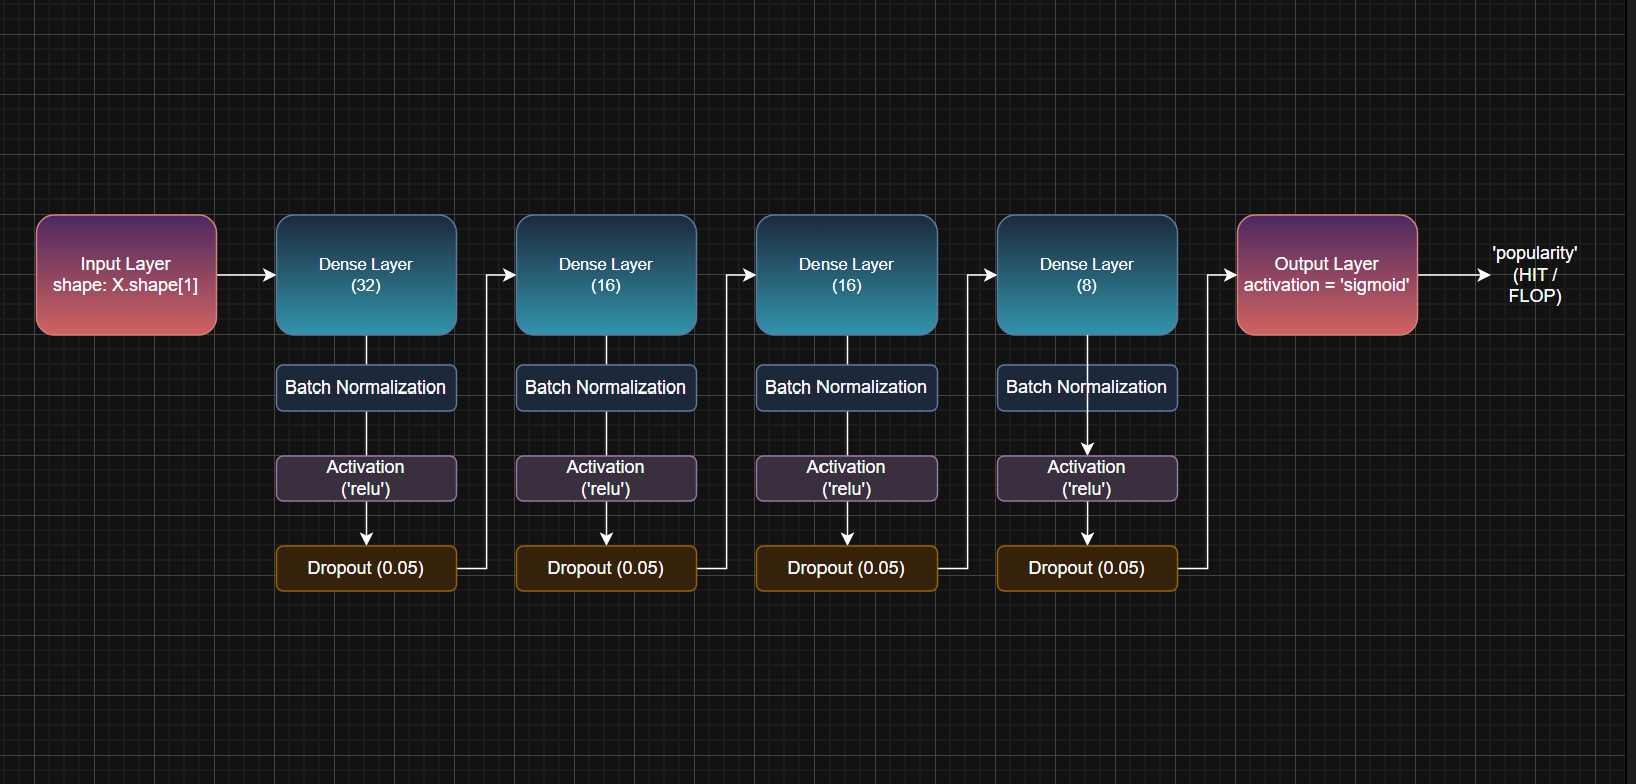

In [ ]:
from IPython.display import Image
Image("109B Final Model Flowchart.png")

**Fig 4.1:**

This flowchart shows the style of the final model.

Now, we will build this model and train it for each dataset ("all", "lim").

In [ ]:
## RUN THIS TO AVOID RUNNING SECTIONS 1-3 (loads the train\validation\test sets from "dataset_splits.npz")
from google.colab import files
uploaded = files.upload()

In [ ]:
## RUN THIS TO AVOID RUNNING SECTIONS 1-3
import numpy as np

# load
data = np.load('dataset_splits.npz')

# unpack datasets
X_train_all = data["X_train_all"]
X_val_all   = data["X_val_all"]
X_test_all  = data["X_test_all"]

y_train_all = data["y_train_all"]
y_val_all   = data["y_val_all"]
y_test_all  = data["y_test_all"]

X_train_lim = data["X_train_lim"]
X_val_lim   = data["X_val_lim"]
X_test_lim  = data["X_test_lim"]

y_train_lim = data["y_train_lim"]
y_val_lim   = data["y_val_lim"]
y_test_lim  = data["y_test_lim"]

FileNotFoundError: [Errno 2] No such file or directory: 'dataset_splits.npz'

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, Precision, Recall, Accuracy
from tensorflow.keras.callbacks import EarlyStopping

def build_final_model(num_features, learning_rate = 0.01, dropout_rate = 0.2):
    numeric_input = Input(shape=(num_features,), name='numeric_input')
    x = numeric_input

    # 01: Dense (32)
    x = Dense(32)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    # 02: Dense (16)
    x = Dense(16)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    # 03: Dense (16)
    x = Dense(16)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    # 04: Dense (8)
    x = Dense(8)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    # output layer
    output = Dense(1, activation = 'sigmoid')(x)

    # model define
    model = Model(inputs = numeric_input, outputs = output)

    # compiling with extra metrics (but keeping Adam)
    model.compile(
        optimizer = Adam(learning_rate = learning_rate),
        loss = BinaryCrossentropy(),
        metrics = ['binary_accuracy', AUC(name = 'auc'), Precision(name = 'precision'), Recall(name = 'recall')]
    )

    return model

In [ ]:
# early stopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

Now, we can fit the "all" model:

In [ ]:
# build model_all
final_model_all = build_final_model(num_features = X_train_all.shape[1], learning_rate = 0.001, dropout_rate = 0.05)

# fit model_all
final_history_all = final_model_all.fit(
    X_train_all,
    y_train_all,
    validation_data = (X_val_all, y_val_all),
    epochs = 25,
    batch_size = 64,
    callbacks=[early_stop]
)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - auc: 0.6698 - binary_accuracy: 0.6199 - loss: 0.6500 - precision: 0.5928 - recall: 0.7923

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


463/463 ━━━━━━━━━━━━━━━━━━━━ 82s 177ms/step - auc: 0.6699 - binary_accuracy: 0.6200 - loss: 0.6499 - precision: 0.5929 - recall: 0.7923 - val_auc: 0.8091 - val_binary_accuracy: 0.7448 - val_loss: 0.5158 - val_precision: 0.7007 - val_recall: 0.8661
Epoch 2/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 83s 179ms/step - auc: 0.8013 - binary_accuracy: 0.7364 - loss: 0.5286 - precision: 0.6982 - recall: 0.8305 - val_auc: 0.8286 - val_binary_accuracy: 0.7622 - val_loss: 0.4937 - val_precision: 0.7240 - val_recall: 0.8571
Epoch 3/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 141s 178ms/step - auc: 0.8221 - binary_accuracy: 0.7512 - loss: 0.5060 - precision: 0.7181 - recall: 0.8279 - val_auc: 0.8416 - val_binary_accuracy: 0.7749 - val_loss: 0.4768 - val_precision: 0.7302 - val_recall: 0.8811
Epoch 4/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 141s 176ms/step - auc: 0.8321 - binary_accuracy: 0.7638 - loss: 0.4898 - precision: 0.7295 - recall: 0.8432 - val_auc: 0.8489 - val_binary_accuracy: 0.7832 - val_loss: 0.4660 - val_precision: 0

And then the "lim" model:

In [ ]:
# build model_lim
final_model_lim = build_final_model(num_features = X_train_lim.shape[1], learning_rate = 0.001, dropout_rate = 0.05)

# fit model_all
final_history_lim = final_model_lim.fit(
    X_train_lim,
    y_train_lim,
    validation_data = (X_val_lim, y_val_lim),
    epochs = 25,
    batch_size = 32,
    callbacks=[early_stop]
)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - auc: 0.6302 - binary_accuracy: 0.5954 - loss: 0.6642 - precision: 0.5850 - recall: 0.6743

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


925/925 ━━━━━━━━━━━━━━━━━━━━ 167s 181ms/step - auc: 0.6302 - binary_accuracy: 0.5954 - loss: 0.6641 - precision: 0.5850 - recall: 0.6744 - val_auc: 0.7084 - val_binary_accuracy: 0.6627 - val_loss: 0.6123 - val_precision: 0.6232 - val_recall: 0.8444
Epoch 2/25
925/925 ━━━━━━━━━━━━━━━━━━━━ 200s 179ms/step - auc: 0.6913 - binary_accuracy: 0.6500 - loss: 0.6244 - precision: 0.6136 - recall: 0.7930 - val_auc: 0.7244 - val_binary_accuracy: 0.6621 - val_loss: 0.6061 - val_precision: 0.6167 - val_recall: 0.8793
Epoch 3/25
925/925 ━━━━━━━━━━━━━━━━━━━━ 165s 179ms/step - auc: 0.7152 - binary_accuracy: 0.6704 - loss: 0.6093 - precision: 0.6346 - recall: 0.8057 - val_auc: 0.7344 - val_binary_accuracy: 0.6764 - val_loss: 0.5981 - val_precision: 0.6331 - val_recall: 0.8583
Epoch 4/25
925/925 ━━━━━━━━━━━━━━━━━━━━ 201s 178ms/step - auc: 0.7189 - binary_accuracy: 0.6713 - loss: 0.6053 - precision: 0.6370 - recall: 0.7940 - val_auc: 0.7425 - val_binary_accuracy: 0.6822 - val_loss: 0.5912 - val_precision:

Model Summaries:

In [ ]:
# model summaries
final_model_all.summary()
final_model_lim.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ numeric_input (InputLayer)      │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,813 (22.71 KB)

 Trainable params: 1,889 (7.38 KB)

 Non-trainable params: 144 (576.00 B)

 Optimizer params: 3,780 (14.77 KB)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ numeric_input (InputLayer)      │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,949 (19.34 KB)

 Trainable params: 1,601 (6.25 KB)

 Non-trainable params: 144 (576.00 B)

 Optimizer params: 3,204 (12.52 KB)

And once again save the models with keras and pickle:

In [ ]:
# save it, save penguins!

from google.colab import drive
import pickle

# mount GDrive
drive.mount('/content/drive')

# saving baseline_all
final_model_all.save("/content/drive/MyDrive/final_model_all_full.keras")
with open("/content/drive/MyDrive/final_history_all.pkl", "wb") as f:
    pickle.dump(final_history_all.history, f)

# saving baseline_lim
final_model_lim.save("/content/drive/MyDrive/final_model_lim_full.keras")
with open("/content/drive/MyDrive/final_history_lim.pkl", "wb") as f:
    pickle.dump(final_history_lim.history, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Section 4.4: Training History Visualization (TBD)

(Start running the code again here after skipping Section 4.3, if you have the .npz file.) Otherwise, like in Section 3, disregard.

First, load the history:

In [ ]:
from tensorflow import keras
import pickle

# final_all

# model
final_model_all = keras.models.load_model("/content/drive/MyDrive/final_model_all_full.keras")

# load saved training history
with open("/content/drive/MyDrive/final_history_all.pkl", "rb") as f:
    final_history_all = pickle.load(f)

In [ ]:
# final_lim

# model
final_model_lim = keras.models.load_model("/content/drive/MyDrive/final_model_lim_full.keras")

# load saved training history
with open("/content/drive/MyDrive/final_history_lim.pkl", "rb") as f:
    final_history_lim = pickle.load(f)

Now, we can make plots of the training history:

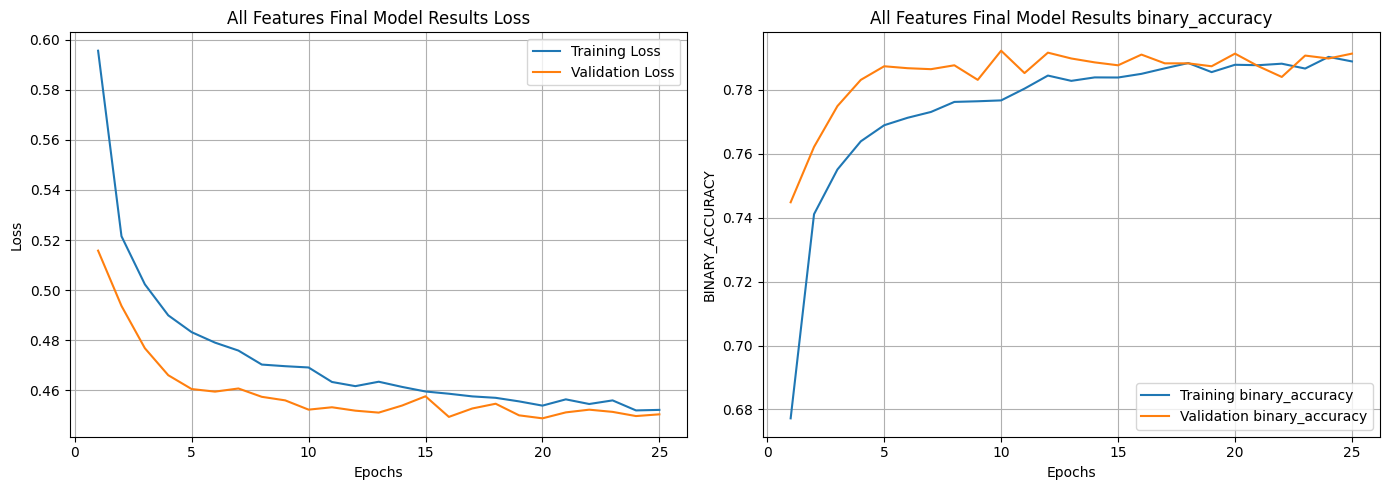

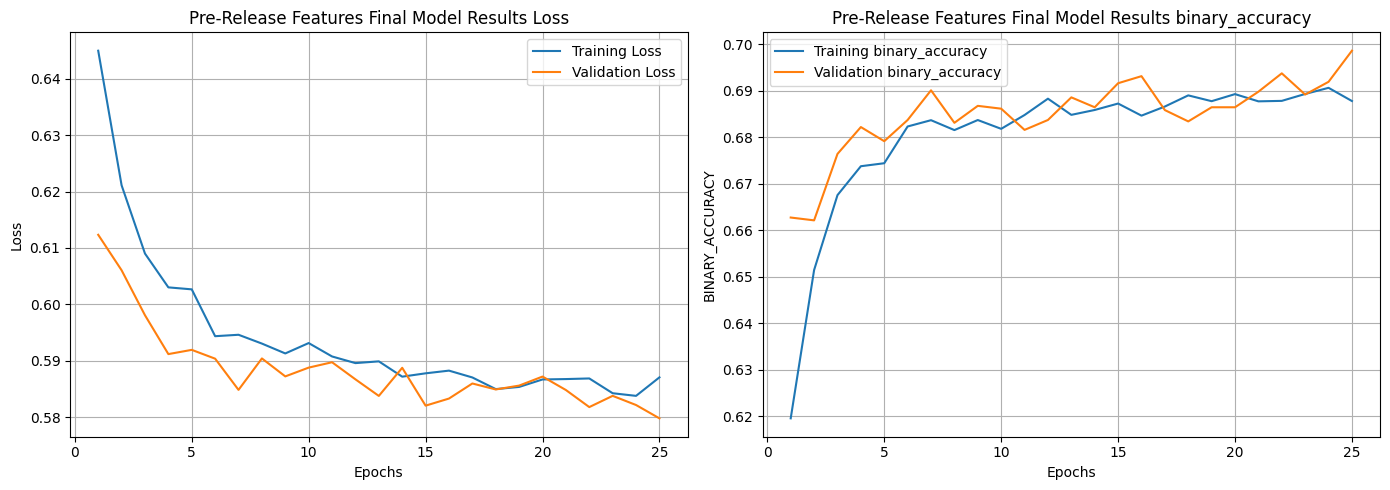

In [ ]:
# plot for "all"
plot_training_history(final_history_all, 'binary_accuracy', title_prefix = 'All Features Final Model Results')

# plot for "lim"
plot_training_history(final_history_lim, 'binary_accuracy', title_prefix = "Pre-Release Features Final Model Results")

**Fig 4.2:**

Training vs. validation history plots tracking loss and binary accuracy for both the full model (all features) and the limited pre-release features (lim).

For our evaluation metrics, we looked at accuracy and our cross-entropy loss to determine how well our model was performing. During our training process, we trained the model with all the features (baseline_model_all) and a model with pre-release features (baseline_model_lim). After training, we achieved a validation accuracy of 79.1% and a loss of 0.449 for our baseline_model_all and for our baseline_model_lim, we got a validation accuracy of 70.0% and a loss of 0.580.


### Section 4.5: Test Predictions

In [ ]:
y_true = y_test_all
y_pred_proba = final_model_all.predict(X_test_all).ravel()
y_pred        = (y_pred_proba >= 0.5).astype(int)
print(f"Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")

  9/257 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
Test Accuracy: 0.7977


In [ ]:
y_pred_proba_lim = final_model_lim.predict(X_test_lim).ravel()
y_pred        = (y_pred_proba_lim >= 0.5).astype(int)
print(f"Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")

  9/257 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Test Accuracy: 0.7062


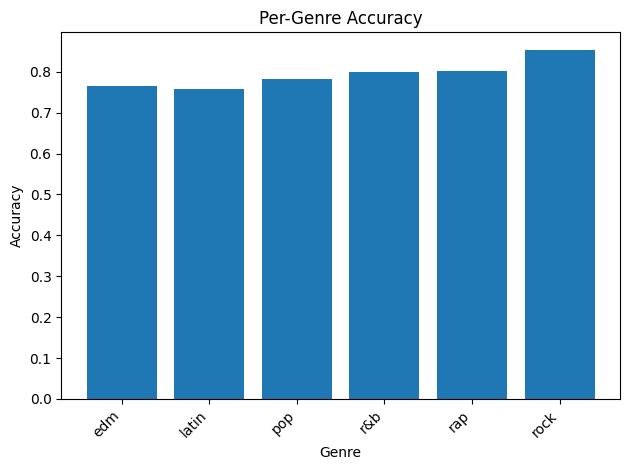

In [ ]:
# 4) Per-Genre Accuracy
from collections import defaultdict

# pull the genre labels for each test sample
genres_list = dataset_cleaned_preprocessed.loc[X_test_all.index, 'genre']

# compute correct counts per genre
genre_correct = defaultdict(int)
genre_total   = defaultdict(int)


for true, pred, g in zip(y_true, y_pred, genres_list):
    genre_total[g] += 1
    if true == pred:
        genre_correct[g] += 1

genres     = sorted(genre_total)
accuracies = [genre_correct[g] / genre_total[g] for g in genres]

plt.figure()
plt.bar(genres, accuracies)
plt.xlabel('Genre')
plt.ylabel('Accuracy')
plt.title('Per-Genre Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Fig 4.3:**

A bar graph displaying the accuracy results by genre (model = 'all'). This demonstrated that despite the imbalance in representation/count in our dataset, the model performed similarly well on all of them!

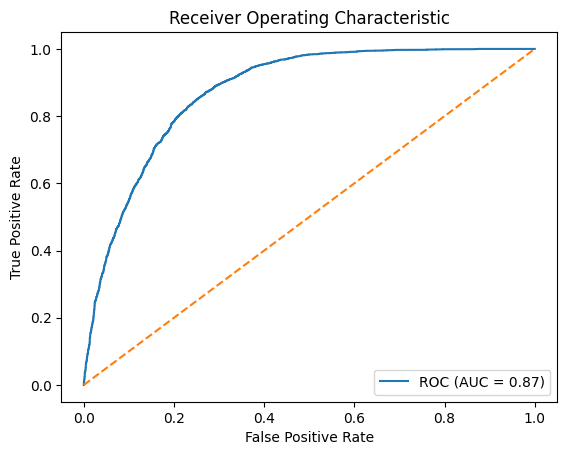

In [ ]:
# Plotting ROC Curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc      = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

**Fig 4.4:**

ROC/AUC curve of our classification for the model  (model = 'all'), which is very good (0.87).

### Section 4.6: A New Testing Dataset: "new_songs"

We don't just want to know how the model does on data from 1960-2019: we want to see how well it generalizes to new data. Hence we are supplementing our test set with a set of new songs from 2020-2023.

"new_songs" is aggregated from two Kaggle datasets. The first dataset has song attributes from 1 million tracks from Spotify. The second dataset, made in 2023, contains all the billboard hot 100 songs going back decades (making this list is the main criteria for hit vs flop). If a song is in the latter dataset, the "popularity" column is set to true; else false, only including those songs which are from 2020 and onward. The dataset is constructed in this fashion, and most of the preprocessing applied, in a separate notebook for the sake of organization. The result of that notebook is imported here as "new_songs.csv" for some final preprocessing.


Sources:
https://www.kaggle.com/datasets/amitanshjoshi/spotify-1million-tracks
https://www.kaggle.com/datasets/dhruvildave/billboard-the-hot-100-songs


In [ ]:
new_songs_file = files.upload()


Saving new_songs.csv to new_songs.csv


In [ ]:
new_songs = pd.read_csv('new_songs.csv')
new_songs.head()

,popularity,genre,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,years_to_2025,key_sin,key_cos,duration_s
0,0,edm,0.512,0.894,-5.396,0,0.0804,0.125,0.727000,0.1650,0.1800,105.024,4,5,0.000000,1.000000,179.453
1,0,edm,0.644,0.349,-5.315,0,0.0364,0.206,0.000034,0.1250,0.2460,94.971,4,5,0.866025,0.500000,198.947
2,0,edm,0.771,0.644,-7.746,1,0.0337,0.522,0.000007,0.0760,0.8310,145.029,4,5,0.866025,-0.500000,235.024
3,0,edm,0.689,0.514,-12.803,1,0.0383,0.512,0.449000,0.0952,0.0963,121.985,4,5,-0.500000,0.866025,238.033
4,0,edm,0.596,0.834,-4.785,1,0.0395,0.225,0.023500,0.1050,0.6740,123.970,4,5,-0.500000,-0.866025,156.801


New_songs is mostly preprocessed in the other notebook, but needs to be genre encoded and scaled in this notebook, which has the encoder and scaler fit to the train data.

In [ ]:
#

new_songs[['chorus_hit', 'sections']] = 0 #impute with zeros to fit robust scaler format; these columns will be dropped anyway
new_songs[['tempo', 'loudness', 'duration_s', 'chorus_hit', 'sections', 'years_to_2025']] = robust_scaler.transform(
    new_songs[['tempo', 'loudness', 'duration_s', 'chorus_hit', 'sections', 'years_to_2025']])

new_songs_encoded = genre_encoder.transform(new_songs[['genre']])
new_songs_encoded_df = pd.DataFrame(new_songs_encoded, columns=genre_encoder.get_feature_names_out(['genre']))
new_songs = pd.concat([new_songs.reset_index(drop=True), new_songs_encoded_df], axis=1)

new_songs = pd.get_dummies(new_songs, columns = ['time_signature'], drop_first=True)
one_hot_cols = ['time_signature_1', 'time_signature_3', 'time_signature_4', 'time_signature_5']
new_songs[one_hot_cols] = new_songs[one_hot_cols].astype(int)

### Section 4.7: Test Predictions for new_songs

In [ ]:
from sklearn.metrics import accuracy_score
y_test_new = new_songs['popularity']

# make first predictor matrix
X_all_test_new = new_songs.drop(columns = ['genre', 'popularity', 'sections', 'chorus_hit'])

y_test_new_probs = final_model_all.predict(X_all_test_new).ravel()
y_test_new_pred = (y_test_new_probs >= 0.5).astype(int)
print(f"Test Accuracy: {accuracy_score(y_test_new, y_test_new_pred):.4f}")

  9/586 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


586/586 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step
Test Accuracy: 0.7168


In [ ]:
X_lim_test_new = X_all_test_new[pre_release_features].copy()

y_test_new_probs = final_model_lim.predict(X_lim_test_new).ravel()
y_test_new_pred = (y_test_new_probs >= 0.5).astype(int)
print(f"Test Accuracy: {accuracy_score(y_test_new, y_test_new_pred):.4f}")

  9/586 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


586/586 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
Test Accuracy: 0.4870


The final_model_all does pretty well on the new dataset, with a test accuracy of 0.7168, but the final_model_lim completely fails, producing essentially a coin flip. This indicates that the Spotify-calculated statistics like danceability and energy are nuanced enough to capture timeless qualities of hits that somehow the pre-release features are simply unable to capture. Music is such a dynamic field that the pre-release features which made a song a hit in the past simply do not apply in the 2020s. So much for our hope of being able to tell an artist what will make a song a hit before he writes the song!



## Section 5: Conclusion

The music industry is a multi-billion dollar global market. Success on music charts translates into sales, streams, and influence. However, much of music is subjective, making it difficult to quantify what becomes the most popular, and therefore, profitable. This project set out to investigate whether a song’s features can predict its popularity and propensity to chart. We explored this question using the Spotify Kaggle dataset, which includes songs from 1960–2019.

After transforming our data, we trained models using two datasets: one containing only the song’s raw features, and another that incorporated additional information from the Spotify API. The full dataset performed better, and we used it to train our final model. Using grid search, we tuned hyperparameters like learning rate, batch normalization, and dropout to achieve a validation accuracy of 79.1% and a test accuracy of 80.0%. When we evaluated our model on a web-scraped dataset with songs from 2020–2023, the test accuracy dropped slightly to 71.7%.

While our baseline model had a marginally higher validation accuracy than our final model (79.8% vs. 79.1%), this suggests a ceiling for the dataset’s performance. Our test accuracy on the final model also exceeded both validation scores, albeit slightly. This ceiling was observed across other Kaggle datasets as well and remained consistent regardless of model complexity, explaining why our baseline and tuned model performed very similarly.

This ceiling points to several important findings. First, song features clearly have predictive power, as shown by our model achieving 80% test accuracy. Furthermore, since incorporating Spotify API features improved performance, this suggests that the interaction of features plays a key role in determining a song’s success. However, even with strong predictive power, the model's accuracy is ultimately limited. Very few Kaggle datasets achieved above 80% accuracy, which may indicate that song features only partially explain popularity. Other factors outside of the dataset, such as artist reputation, marketing spend, and label backing likely influence a song’s chart potential. Additionally, some degree of chart success may simply come down to luck, which no model can quantify.

Using feature importance via random forests, we identified which features contributed most to popularity. Instrumentalness, acousticness, and danceability were the most predictive, suggesting that listeners generally prefer danceable, non-acoustic songs with strong vocals. Future work could include applying feature importance techniques like SHAP to our neural network and scraping new features to improve predictive power.
